Performing STFT with `n_fft=512` for a frequency resolution of approximately 0.3906 Hz, focusing on frequencies up to 20 Hz, which covers EEG's lower frequency bands (Delta through lower Beta). The analysis involves extracting the first 51 rows from the STFT results to capture this range, essential for examining typical brainwave activities in EEG data.

Feature: {x}Hz_{y}percentile_{z}channel

Sampler attention map generating:
用combined montage预测结果，制作y和1-y的pdf
分别处理两种MONTAGE的attention map。制作两个attention map。对于每种montage，转化为stft后log, 并先删除无意义频道，test sample的每个时间点对应一个tile。对于每个tile，只有51种频率以及五个频道。每个频道的频率自上而下为由低到高。之后要normalize attention score

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pywt, librosa 
import multiprocessing
from multiprocessing import Pool
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier,Pool 
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import gaussian_kde


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Training on CPU")

cpu_count = multiprocessing.cpu_count()
print(cpu_count)

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

from config.constants import *
from viz.plot import *
from features.statistical_features import*
from tracking.save_log import *
from features.process_eeg import*
from models.train import*

Training on GPU: NVIDIA GeForce RTX 3080 Laptop GPU
16


In [2]:
class CFG:
    seed = 48
    debug = False
    one_fold = False


    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 300
    batch_size = 64    
    lr = 0.0001
    L1 = 0.0001
    
torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
random.seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

In [3]:
READ_EEG = False
GENERATE_DATA = False
READ_SAMPLER = True
DATA_CLEANING = True

Data Cleaning & Preprocess

In [4]:
if READ_EEG:

    eeg_montage_path = f"{PROCESSED_DATA_DIR}/eeg_data_dict.pickle"
    with open(eeg_montage_path, 'rb') as handle:
        eeg_data_dict = pickle.load(handle)

In [5]:
filtered_csv_path =  f"{PROCESSED_DATA_DIR}/filtered_df_probabilities.csv"
filtered_df = pd.read_csv(filtered_csv_path)
print(filtered_df.shape)
unique_eeg_ids_first_occurrence = filtered_df.drop_duplicates(subset=['eeg_id']).index.tolist()
filtered_df_2 = filtered_df.drop_duplicates(subset=['eeg_id'])
filtered_df_2.head()

(28387, 16)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,level_1
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,0
2,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,9
3,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,11
4,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,22
5,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,28


In [6]:
if READ_SAMPLER:
    processed_sample_df = pd.read_csv(f"{PROCESSED_DATA_DIR}/SAMPLER_STFT.csv")
    processed_sample_df_trans = pd.read_csv(f"{PROCESSED_DATA_DIR}/SAMPLER_STFT_TRANS.csv")
    processed_sampler_df_512 = pd.read_csv(f"{PROCESSED_DATA_DIR}/SAMPLER_STFT_512.csv")
    processed_sampler_df_256 = pd.read_csv(f"{PROCESSED_DATA_DIR}/SAMPLER_STFT_256.csv")

In [8]:
if READ_SAMPLER:
    #delete unwanted rows
    #processed_sample_df_trans = processed_sample_df_trans.drop(columns=['Unnamed: 0'])

    #encode in order
    original_labels = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

    label_to_int = {label: idx for idx, label in enumerate(original_labels)}

    processed_sample_df['encoded_target'] = processed_sample_df['target'].map(label_to_int)
    processed_sample_df_trans['encoded_target'] = processed_sample_df_trans['target'].map(label_to_int)
    processed_sampler_df_512['encoded_target'] = processed_sample_df_trans['target'].map(label_to_int)
    processed_sampler_df_256['encoded_target'] = processed_sampler_df_256['target'].map(label_to_int)
    ######log1p
    processed_sample_df.iloc[:, :-4] = np.log1p(processed_sample_df.iloc[:, :-4])
    processed_sample_df_trans.iloc[:, :-4] = np.log1p(processed_sample_df_trans.iloc[:, :-4])
    processed_sampler_df_512.iloc[:, :-4] = np.log1p(processed_sampler_df_512.iloc[:, :-4])
    processed_sampler_df_256.iloc[:, :-4] = np.log1p(processed_sampler_df_256.iloc[:, :-4])
    



In [ ]:
if GENERATE_DATA:
    eeg_id_with_Nahs = []  # 用来存储Nah比例超过10%的eeg_id

    removed_count = 0  # 初始化计数器，用于追踪剔除的EEG ID数量

    for index, (key, value) in enumerate(eeg_data_dict.items()):
        if index not in unique_eeg_ids_first_occurrence:
            continue
        data = value.get('data')
        eeg_id = value.get("eeg_id")

        if data is None or eeg_id is None:
            print("Missing data or EEG ID.")
            continue

        if not isinstance(data, (pd.DataFrame, pd.Series)):
            print("Data is not a pandas data structure.")
            continue

        null_sum = data.isnull().sum()

        # 如果data是DataFrame，我们需要获得一个总和值
        if isinstance(null_sum, pd.Series):
            null_sum = null_sum.sum()

        total_data_points = data.size if isinstance(data, pd.Series) else data.values.size
        null_percent = (null_sum / total_data_points) * 100  # 计算NaN的百分比

        if null_percent > 10:
            eeg_id_with_Nahs.append(eeg_id)

            removed_count += 1  # 若eeg_id被添加至列表，计数器加1

        print(f"There's {null_sum} NaN in {eeg_id}, percent: {null_percent:.2f}%")

    print(f"Total EEG IDs removed: {removed_count}")  # 打印被剔除的EEG ID总数


In [ ]:

def merge_eeg(processed_data):
    group_1_4_mean = processed_data[:, 0:4].mean(axis=1)
    group_5_8_mean = processed_data[:, 4:8].mean(axis=1)
    group_9_12_mean = processed_data[:, 8:12].mean(axis=1)
    group_13_17_mean = processed_data[:, 12:17].mean(axis=1)
    group_18_19_mean = processed_data[:, 17:19].mean(axis=1)

    # 将计算得到的平均值合并成一个新数组
    processed_data_merged = np.vstack([group_1_4_mean, group_5_8_mean, group_9_12_mean, group_13_17_mean, group_18_19_mean]).T
    return processed_data_merged


In [ ]:
if GENERATE_DATA:
    n_channels = 5 
    n_percentiles = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]  
    freq_resolution = 0.39  
    n_freqs = 51  

    # Generate column names for the DataFrame
    # for instance, the 1st 51 colomn should be 5% sampler in different freqs
    columns = []
    for z in range(n_channels):
        for y in n_percentiles:
            for x in range(n_freqs):
                freq = x * freq_resolution  # Calculate frequency
                col_name = f"{freq:.2f}Hz_{y}percentile_{z+1}channel"  # Format column name
                columns.append(col_name)

    features_df = pd.DataFrame(columns=columns)

    features_df['target'] = None
    features_df['probability'] = None
    features_df['eeg_id'] = None

In [ ]:
if GENERATE_DATA:
    filtered_df_2 = filtered_df_2.set_index('eeg_id')

In [ ]:
if GENERATE_DATA:
    

    for index, (key, value) in enumerate(eeg_data_dict.items()):

        if index not in unique_eeg_ids_first_occurrence or value["eeg_id"] in eeg_id_with_Nahs:
            continue
        
        # data = value['data'].to_numpy()
        # mean_value = np.nanmean(data)
        # data[np.isnan(data)] = mean_value
        data = value['data']
        # transform to spectrogram
        data = spectrogram_from_eeg_stft(data, spe_width=1024, n_fft=512, spe_win=256, display=False)

        #I'm actually freaking dead here
        processed_sample = []
        for i in range(data.shape[2]):  # assume 5 channels
            single_channel_data = data[:, :, i]
            sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)#shape = [10,51]
            processed_sample.extend(sampler_result.flatten())  # Flatten and add to list
        
        if len(columns) == len(processed_sample):
            new_row = dict(zip(columns, processed_sample))
        else:
            print("Error: The number of columns and processed sample values do not match.")
        # Append the new row to the DataFrame
        new_row = dict(zip(columns, processed_sample))
        new_row['target'] = filtered_df_2.loc[int(value["eeg_id"]), "expert_consensus"]
        new_row['probability'] = value['targets']
        new_row['eeg_id'] = value["eeg_id"]
        
        new_row_df = pd.DataFrame([new_row])
        
        features_df = pd.concat([features_df, new_row_df], ignore_index=True)

        if (index + 1) % 2000 == 0:
            print(f"Processed {index + 1} samples.")


In [ ]:
#features_df.to_csv(f"{PROCESSED_DATA_DIR}/SAMPLER_STFT_256.csv",index=False)

In [ ]:
merged_df = pd.merge(processed_sample_df, filtered_df_2[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']],
                     on='eeg_id', how='left')


merged_df.head()


Remove features based on ANOVA

In [10]:
#from statsmodels.stats.anova import f_oneway

def remove_features_with_low_anova_significance(dataframe, threshold):

  features = dataframe.columns[:-4]
  #target = dataframe["encoded_target"]
  removed_features = []

  for feature in features:
    data_groups = [dataframe[dataframe["encoded_target"] == i][feature] for i in range(6)]
    f_value, p_value = stats.f_oneway(*data_groups)

    if p_value > threshold:
      removed_features.append(feature)

  # 打印结果
  print("Removed Features:", removed_features)
  print("Number of Removed Features:", len(removed_features))

  dataframe = dataframe.drop(columns=removed_features)

  return dataframe



In [ ]:
    # processed_sample_df.iloc[:, :-4] = np.log1p(processed_sample_df.iloc[:, :-4])
    # processed_sample_df_trans.iloc[:, :-4] = np.log1p(processed_sample_df_trans.iloc[:, :-4])
    # processed_sampler_df_512.iloc[:, :-4] = np.log1p(processed_sampler_df_512.iloc[:, :-4])
    # processed_sampler_df_256.iloc[:, :-4] = np.log1p(processed_sampler_df_256.iloc[:, :-4])

In [21]:
processed_sample_df_cleaned = remove_features_with_low_anova_significance(processed_sample_df, threshold=0.0001)
processed_sample_df_cleaned_trans = remove_features_with_low_anova_significance(processed_sample_df_trans, threshold=0.0001)
processed_sample_df_cleaned_512 = remove_features_with_low_anova_significance(processed_sampler_df_512, threshold=0.0001)
processed_sample_df_cleaned_256 = remove_features_with_low_anova_significance(processed_sampler_df_256, threshold=0.0001)

Removed Features: ['1.56Hz_5percentile_1channel', '1.95Hz_5percentile_1channel', '1.95Hz_15percentile_1channel', '0.00Hz_15percentile_2channel', '0.39Hz_15percentile_2channel', '0.78Hz_15percentile_2channel', '1.17Hz_15percentile_2channel', '1.56Hz_15percentile_2channel', '0.00Hz_25percentile_2channel', '0.39Hz_25percentile_2channel', '0.78Hz_25percentile_2channel', '1.17Hz_25percentile_2channel', '1.56Hz_5percentile_3channel', '1.95Hz_5percentile_3channel', '1.56Hz_15percentile_3channel', '1.95Hz_15percentile_3channel', '0.00Hz_25percentile_5channel', '0.39Hz_25percentile_5channel', '0.78Hz_25percentile_5channel', '1.17Hz_25percentile_5channel', '0.00Hz_35percentile_5channel', '0.39Hz_35percentile_5channel', '0.78Hz_35percentile_5channel', '0.00Hz_45percentile_5channel', '0.39Hz_45percentile_5channel', '0.78Hz_45percentile_5channel']
Number of Removed Features: 26
Removed Features: ['0.39Hz_5percentile_1channel', '0.78Hz_5percentile_1channel', '1.17Hz_5percentile_1channel', '1.56Hz_5p

In [33]:
processed_sample_df_cleaned_512_005 = remove_features_with_low_anova_significance(processed_sampler_df_512, threshold=0.05)
processed_sample_df_cleaned_256_005 = remove_features_with_low_anova_significance(processed_sampler_df_256, threshold=0.05)

Removed Features: ['0.00Hz_5percentile_1channel', '0.39Hz_5percentile_1channel', '19.50Hz_5percentile_1channel', '0.00Hz_15percentile_1channel', '0.39Hz_15percentile_1channel', '19.50Hz_15percentile_1channel', '0.00Hz_25percentile_1channel', '0.39Hz_25percentile_1channel', '19.11Hz_25percentile_1channel', '19.50Hz_25percentile_1channel', '0.00Hz_35percentile_1channel', '0.39Hz_35percentile_1channel', '19.11Hz_35percentile_1channel', '19.50Hz_35percentile_1channel', '18.33Hz_45percentile_1channel', '18.72Hz_45percentile_1channel', '19.11Hz_45percentile_1channel', '19.50Hz_45percentile_1channel', '19.11Hz_55percentile_1channel', '19.50Hz_55percentile_1channel', '19.11Hz_65percentile_1channel', '19.50Hz_65percentile_1channel', '1.95Hz_75percentile_1channel', '2.34Hz_75percentile_1channel', '2.73Hz_75percentile_1channel', '19.11Hz_75percentile_1channel', '19.50Hz_75percentile_1channel', '1.56Hz_85percentile_1channel', '1.95Hz_85percentile_1channel', '2.34Hz_85percentile_1channel', '2.73Hz_

In [ ]:
plot_pdf_combined_classes(processed_sample_df_cleaned.iloc[:,100:108].to_numpy(),processed_sample_df_cleaned.iloc[:, -7].to_numpy(), original_labels, features_per_row=4, linespace = 50, bw_method=0.2)

In [ ]:
plot_pdf_combined_classes(processed_sample_df_cleaned_trans.iloc[:,100:108].to_numpy(), processed_sample_df_cleaned_trans.iloc[:, -1].to_numpy(), original_labels, features_per_row=4, linespace = 50, bw_method=0.2)

In [23]:
X = processed_sample_df_cleaned.iloc[:, :-4]
y = processed_sample_df_cleaned.iloc[:, -1]

In [24]:
X_trans=processed_sample_df_cleaned_trans.iloc[:,:-4]
y_trans = processed_sample_df_cleaned_trans.iloc[:,-1]#It's the same as y actually

In [ ]:
# are_equal = np.array_equal(y, y_trans)

# print(f"Are the two arrays equal? {are_equal}")

In [25]:
X_combined = np.concatenate((X,X_trans),axis = 1)
X_combined.shape

(17001, 5053)

In [26]:
params = {
    'iterations': 3000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'devices': '0:1',
    'verbose': 500,
    'random_seed': 42
}

0:	learn: 1.7389045	test: 1.7424176	best: 1.7424176 (0)	total: 72.2ms	remaining: 3m 36s
500:	learn: 0.6068787	test: 0.8911625	best: 0.8911625 (500)	total: 30.5s	remaining: 2m 32s
1000:	learn: 0.4104470	test: 0.8406624	best: 0.8406624 (1000)	total: 1m	remaining: 2m
1500:	learn: 0.3004804	test: 0.8232284	best: 0.8232145 (1499)	total: 1m 29s	remaining: 1m 29s
2000:	learn: 0.2281270	test: 0.8171928	best: 0.8171917 (1998)	total: 1m 59s	remaining: 59.5s
bestTest = 0.8151624971
bestIteration = 2201
Shrink model to first 2202 iterations.


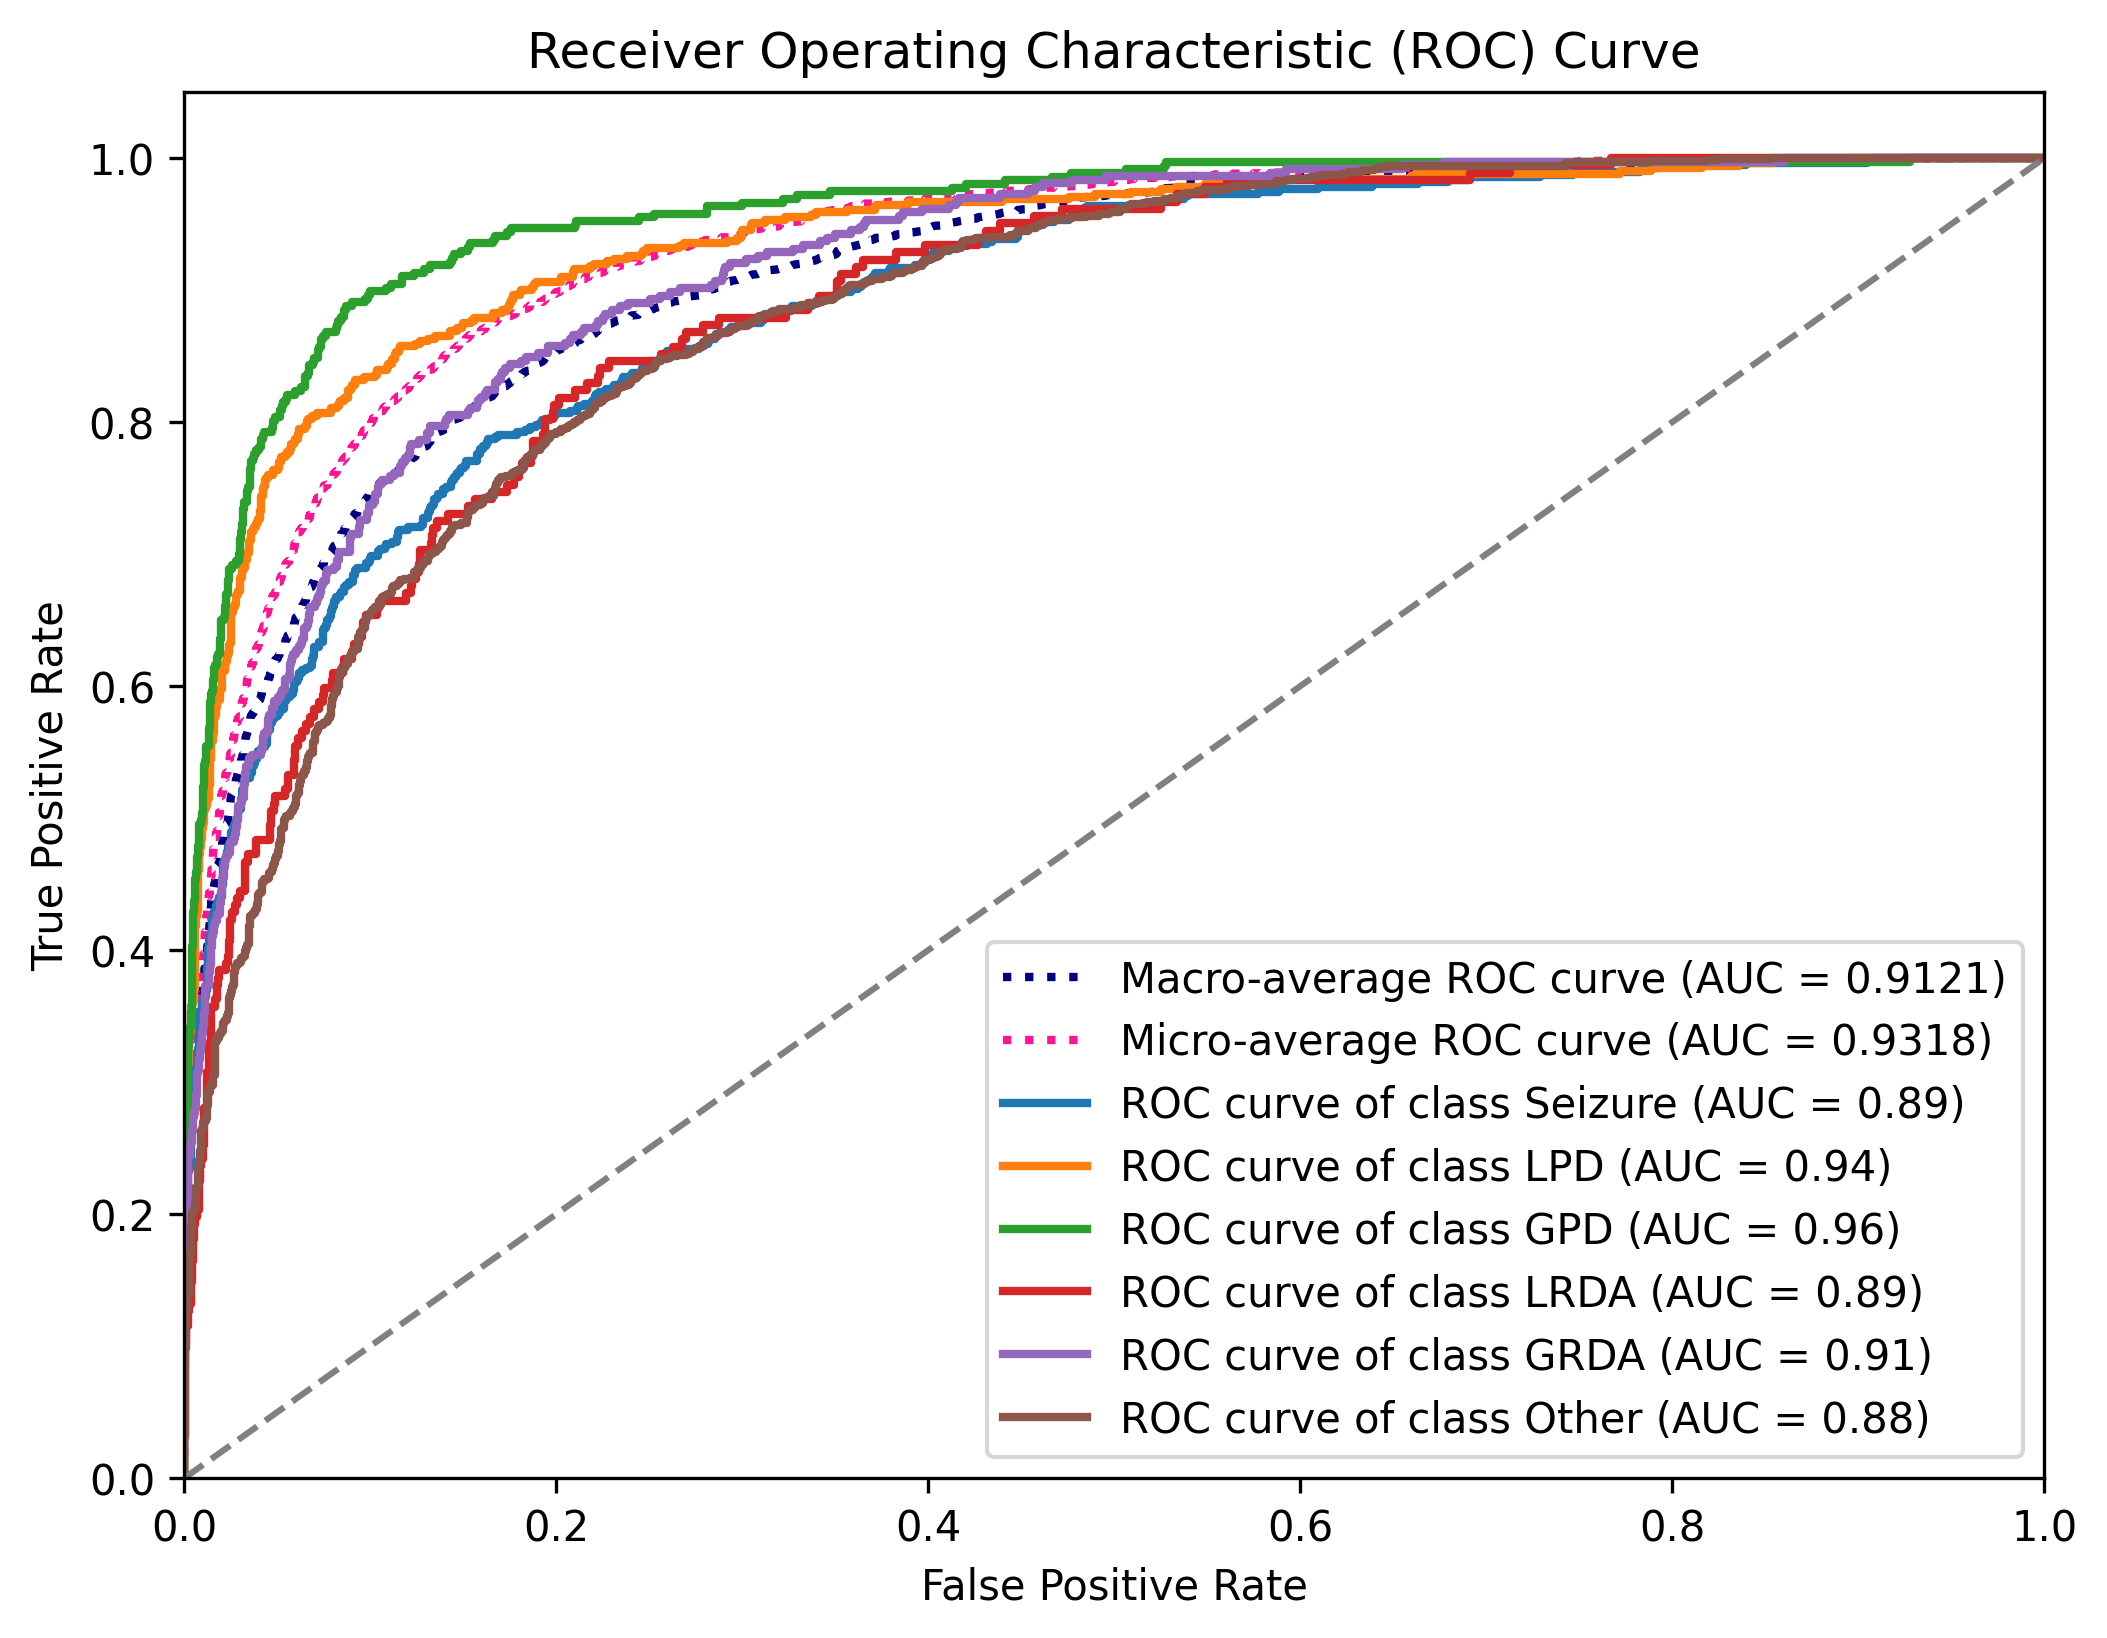

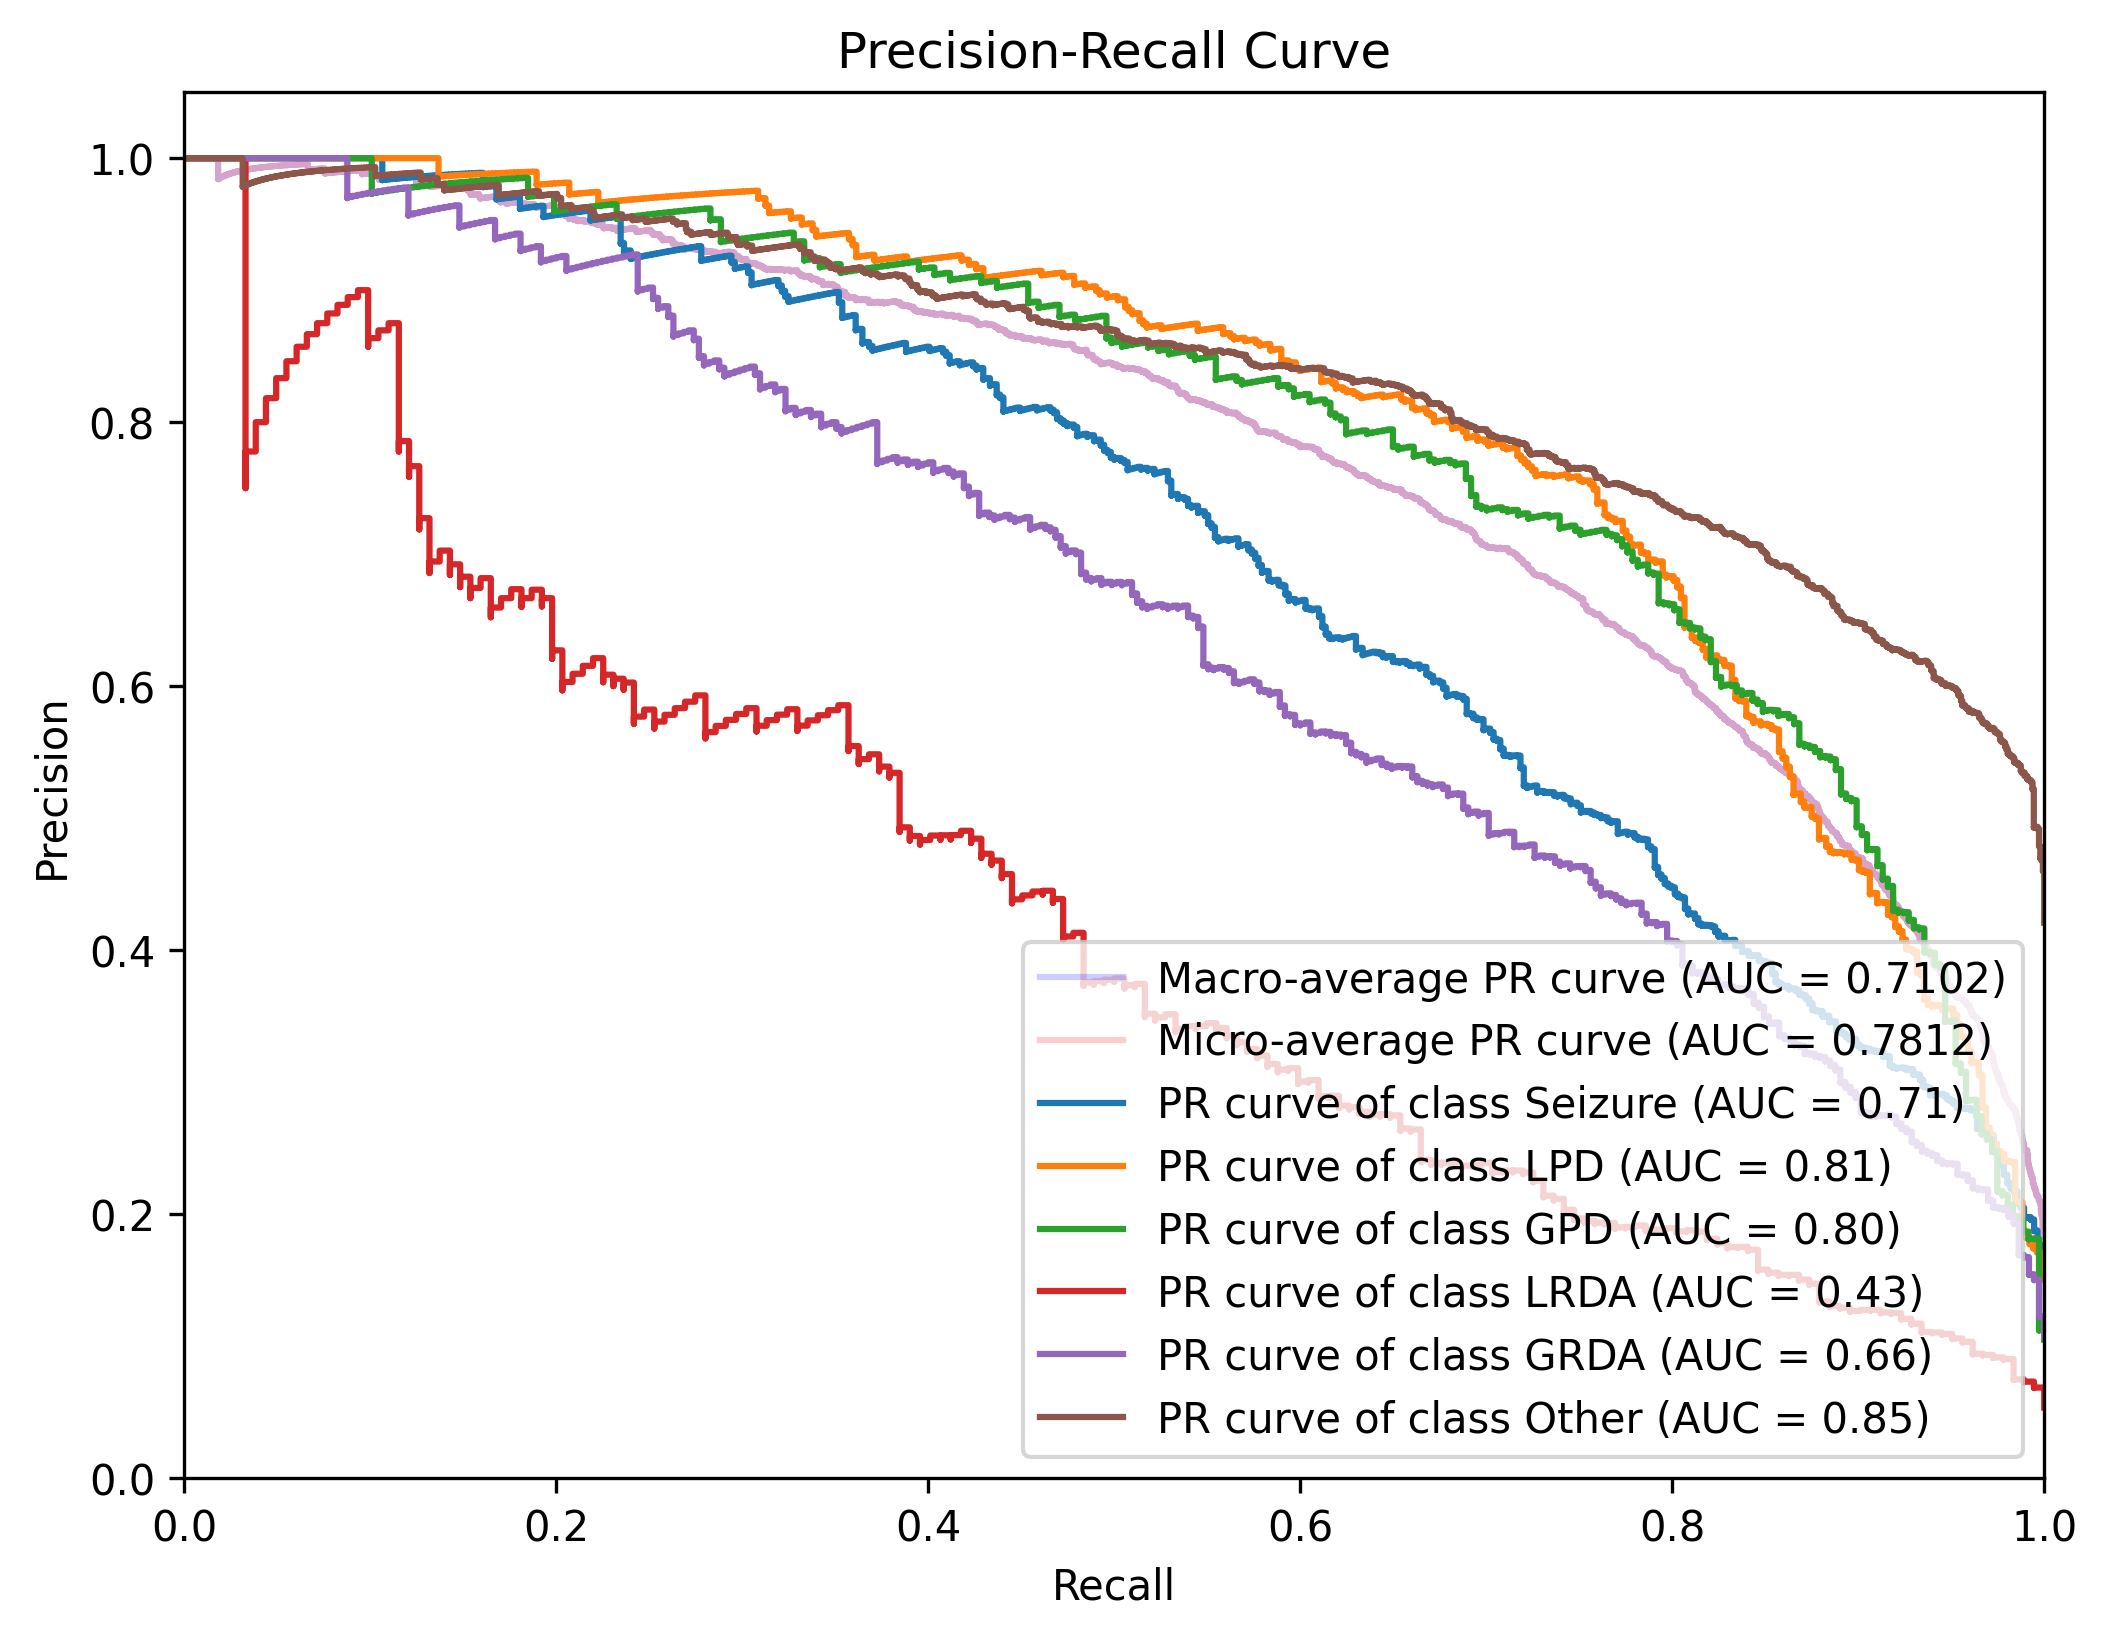

In [32]:
#重新训练，使得TEST SET里数目一样

# 创建数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

model, y_pred, y_pred_proba = train_catboost_classifier(X_train, y_train, X_val, y_val, X_test, y_test, **params)

plot_multiclass_roc_auc(y_test, y_pred_proba, original_labels)
plot_multiclass_pr_auc(y_test, y_pred_proba, original_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

model_trans, y_pred, y_pred_proba = train_catboost_classifier(X_train, y_train, X_val, y_val, X_test, y_test, **params)

plot_multiclass_roc_auc(y_test, y_pred_proba, original_labels)
plot_multiclass_pr_auc(y_test, y_pred_proba, original_labels)

0:	learn: 1.7360587	test: 1.7398547	best: 1.7398547 (0)	total: 224ms	remaining: 11m 11s
500:	learn: 0.5680578	test: 0.8650875	best: 0.8650875 (500)	total: 57.6s	remaining: 4m 47s
1000:	learn: 0.3726193	test: 0.8097770	best: 0.8097770 (1000)	total: 1m 54s	remaining: 3m 48s
1500:	learn: 0.2662711	test: 0.7928954	best: 0.7928276 (1487)	total: 2m 50s	remaining: 2m 50s
bestTest = 0.7875630457
bestIteration = 1838
Shrink model to first 1839 iterations.


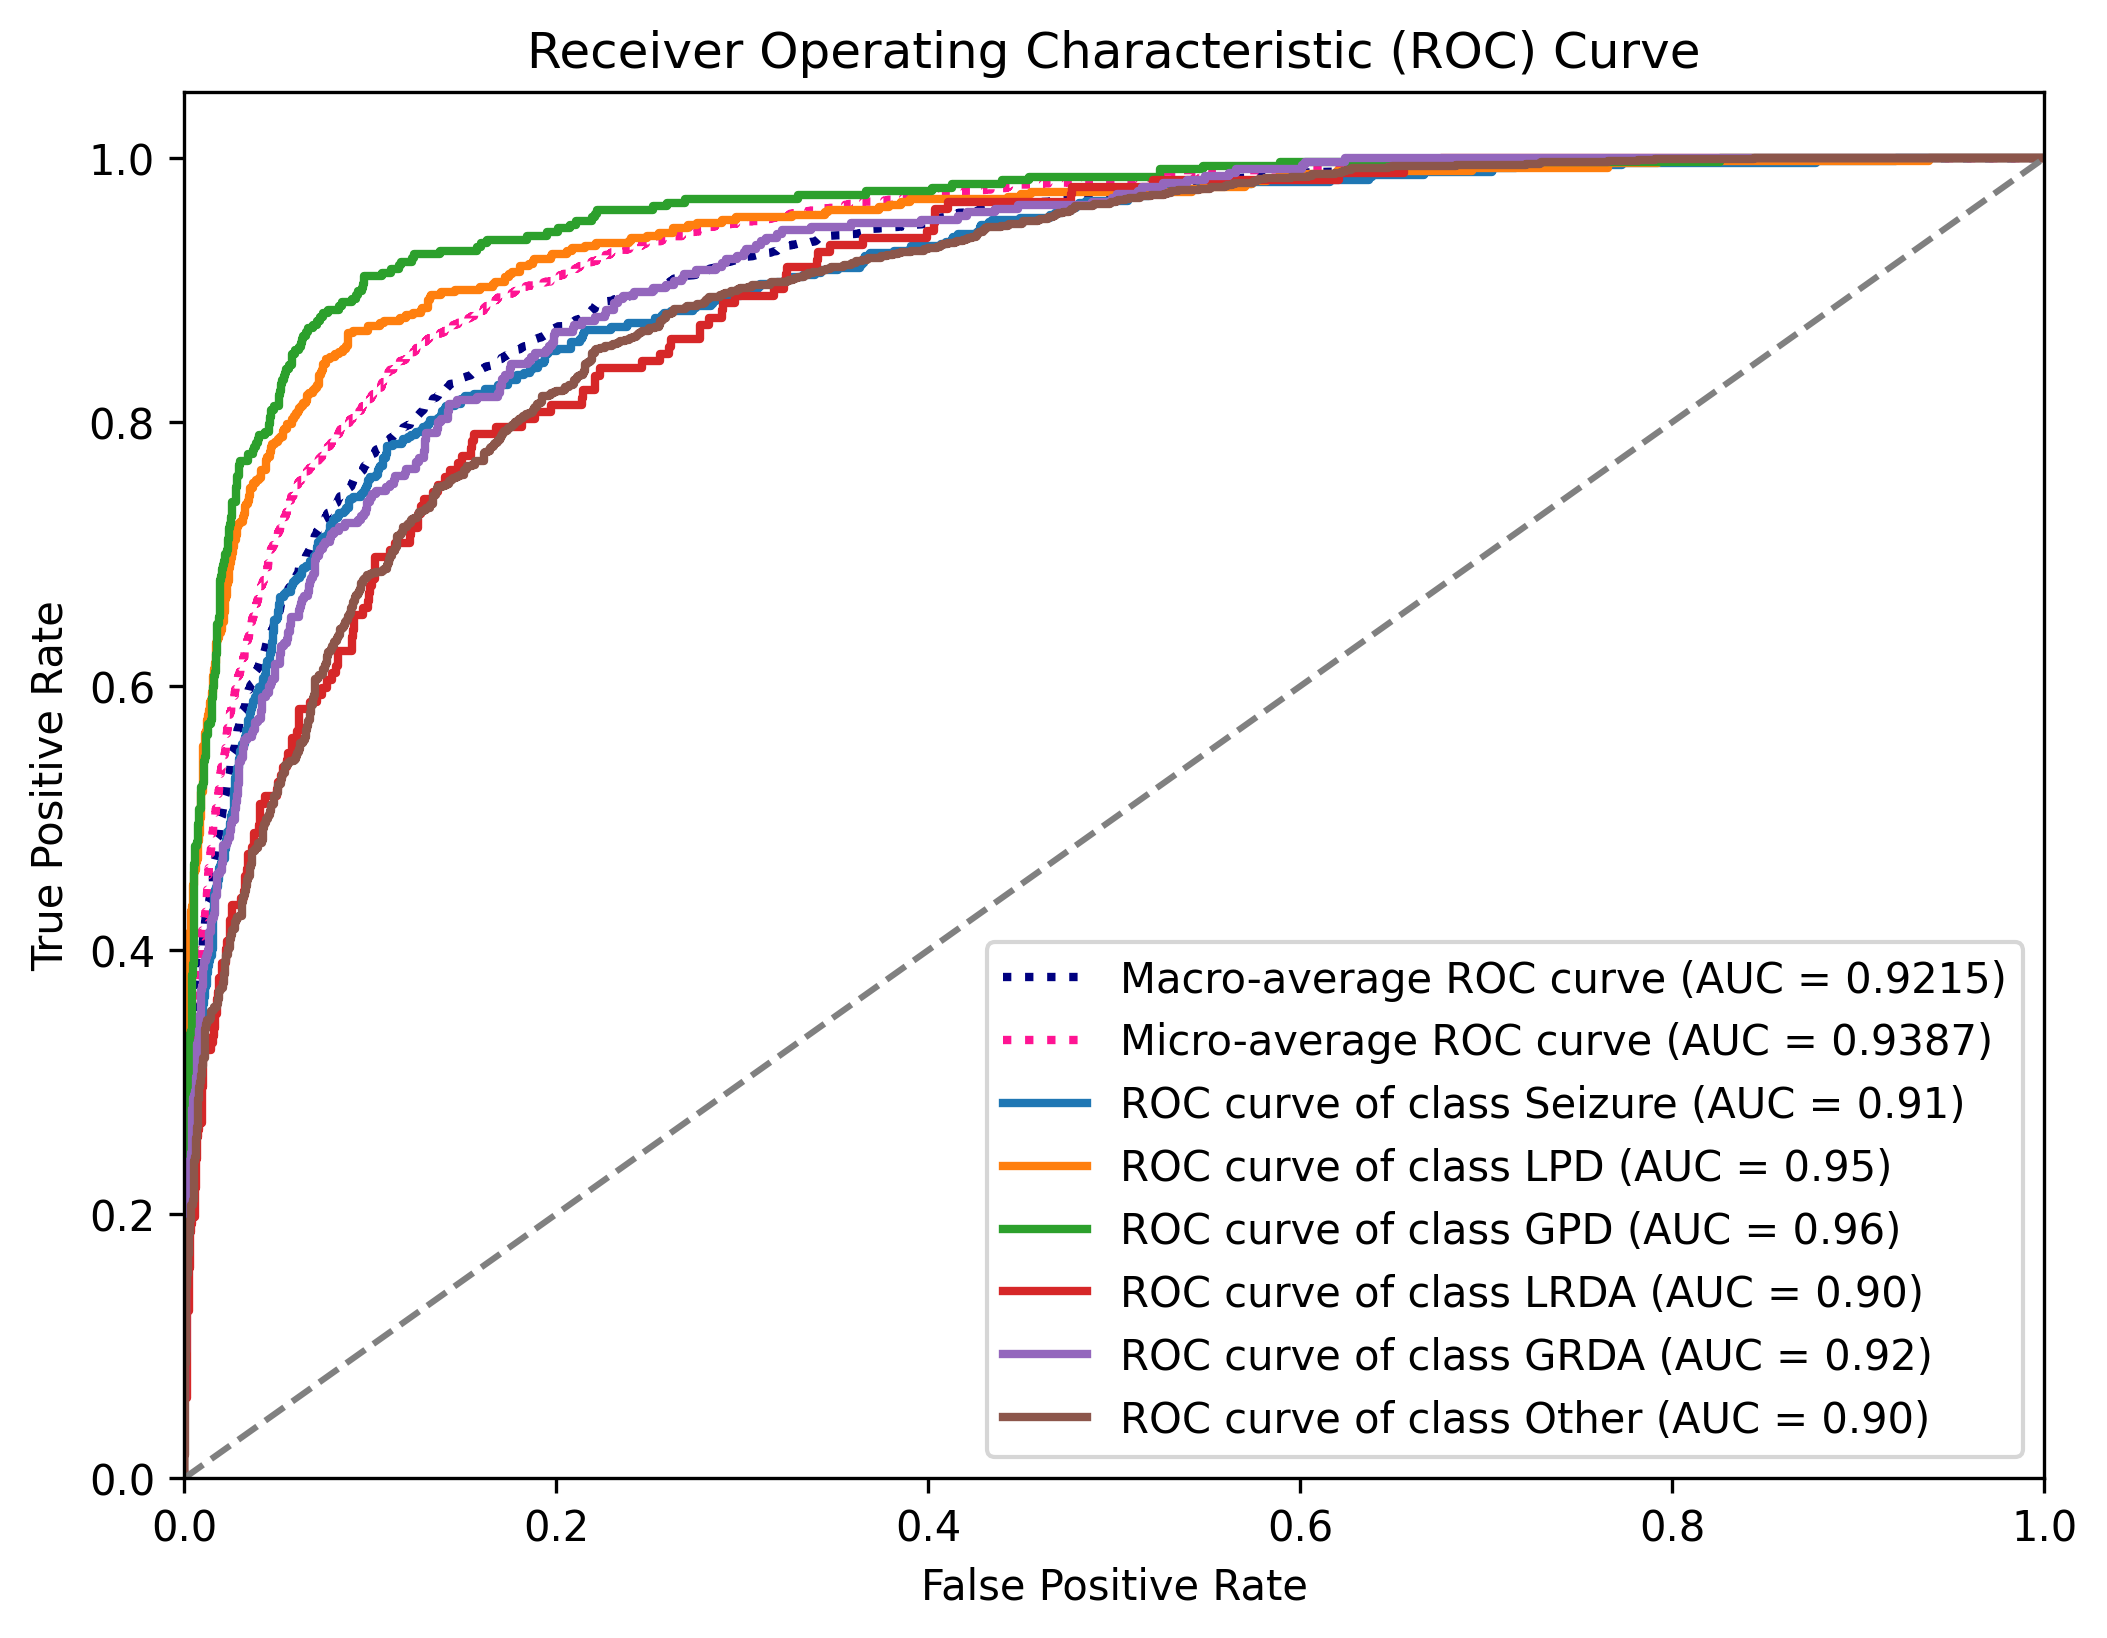

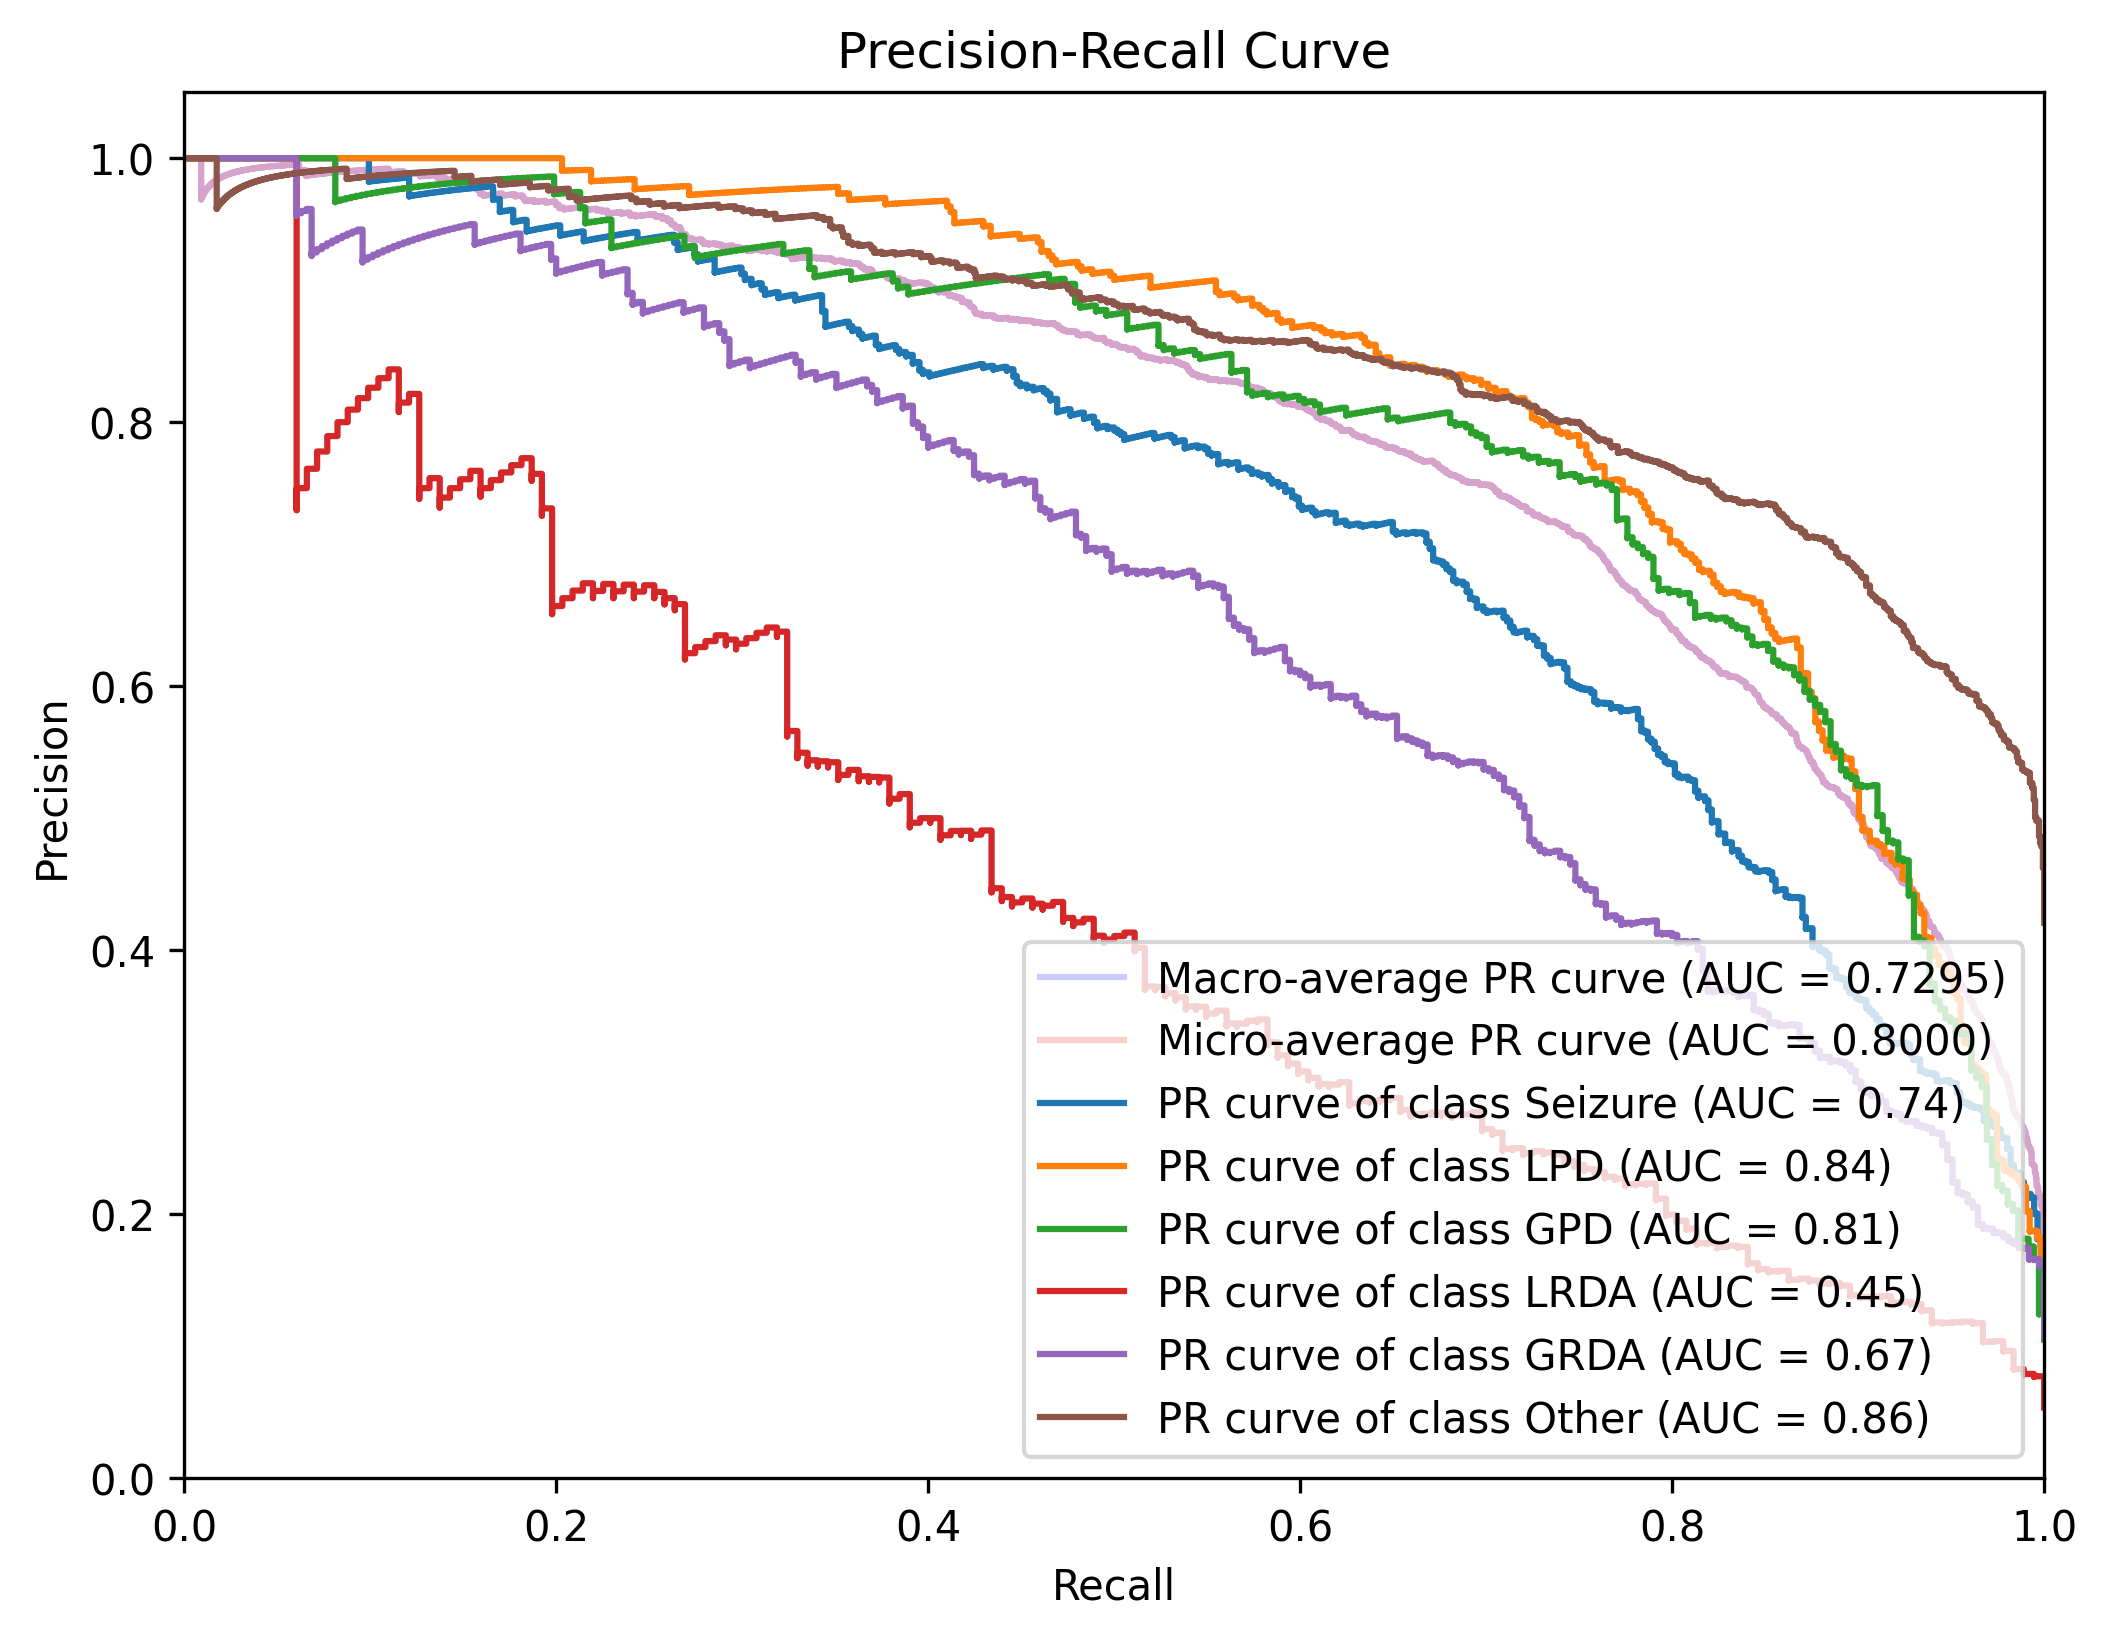

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_trans, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

model_combined, y_pred, y_pred_proba = train_catboost_classifier(X_train, y_train, X_val, y_val, X_test, y_test, **params)

plot_multiclass_roc_auc(y_test, y_pred_proba, original_labels)
plot_multiclass_pr_auc(y_test, y_pred_proba, original_labels)

In [28]:
x_512 = processed_sample_df_cleaned_512.iloc[:, :-4]
x_256 = processed_sample_df_cleaned_256.iloc[:, :-4]
X_combined_all_size = np.concatenate((X,x_512,x_256),axis = 1)

0:	learn: 1.7356666	test: 1.7390456	best: 1.7390456 (0)	total: 376ms	remaining: 18m 46s
500:	learn: 0.5553937	test: 0.8443565	best: 0.8443565 (500)	total: 1m 11s	remaining: 5m 59s
1000:	learn: 0.3643097	test: 0.7939653	best: 0.7939447 (999)	total: 2m 23s	remaining: 4m 46s
1500:	learn: 0.2608194	test: 0.7771660	best: 0.7771243 (1499)	total: 3m 32s	remaining: 3m 32s
2000:	learn: 0.1959618	test: 0.7710572	best: 0.7710564 (1986)	total: 4m 42s	remaining: 2m 21s
bestTest = 0.7700848748
bestIteration = 2115
Shrink model to first 2116 iterations.


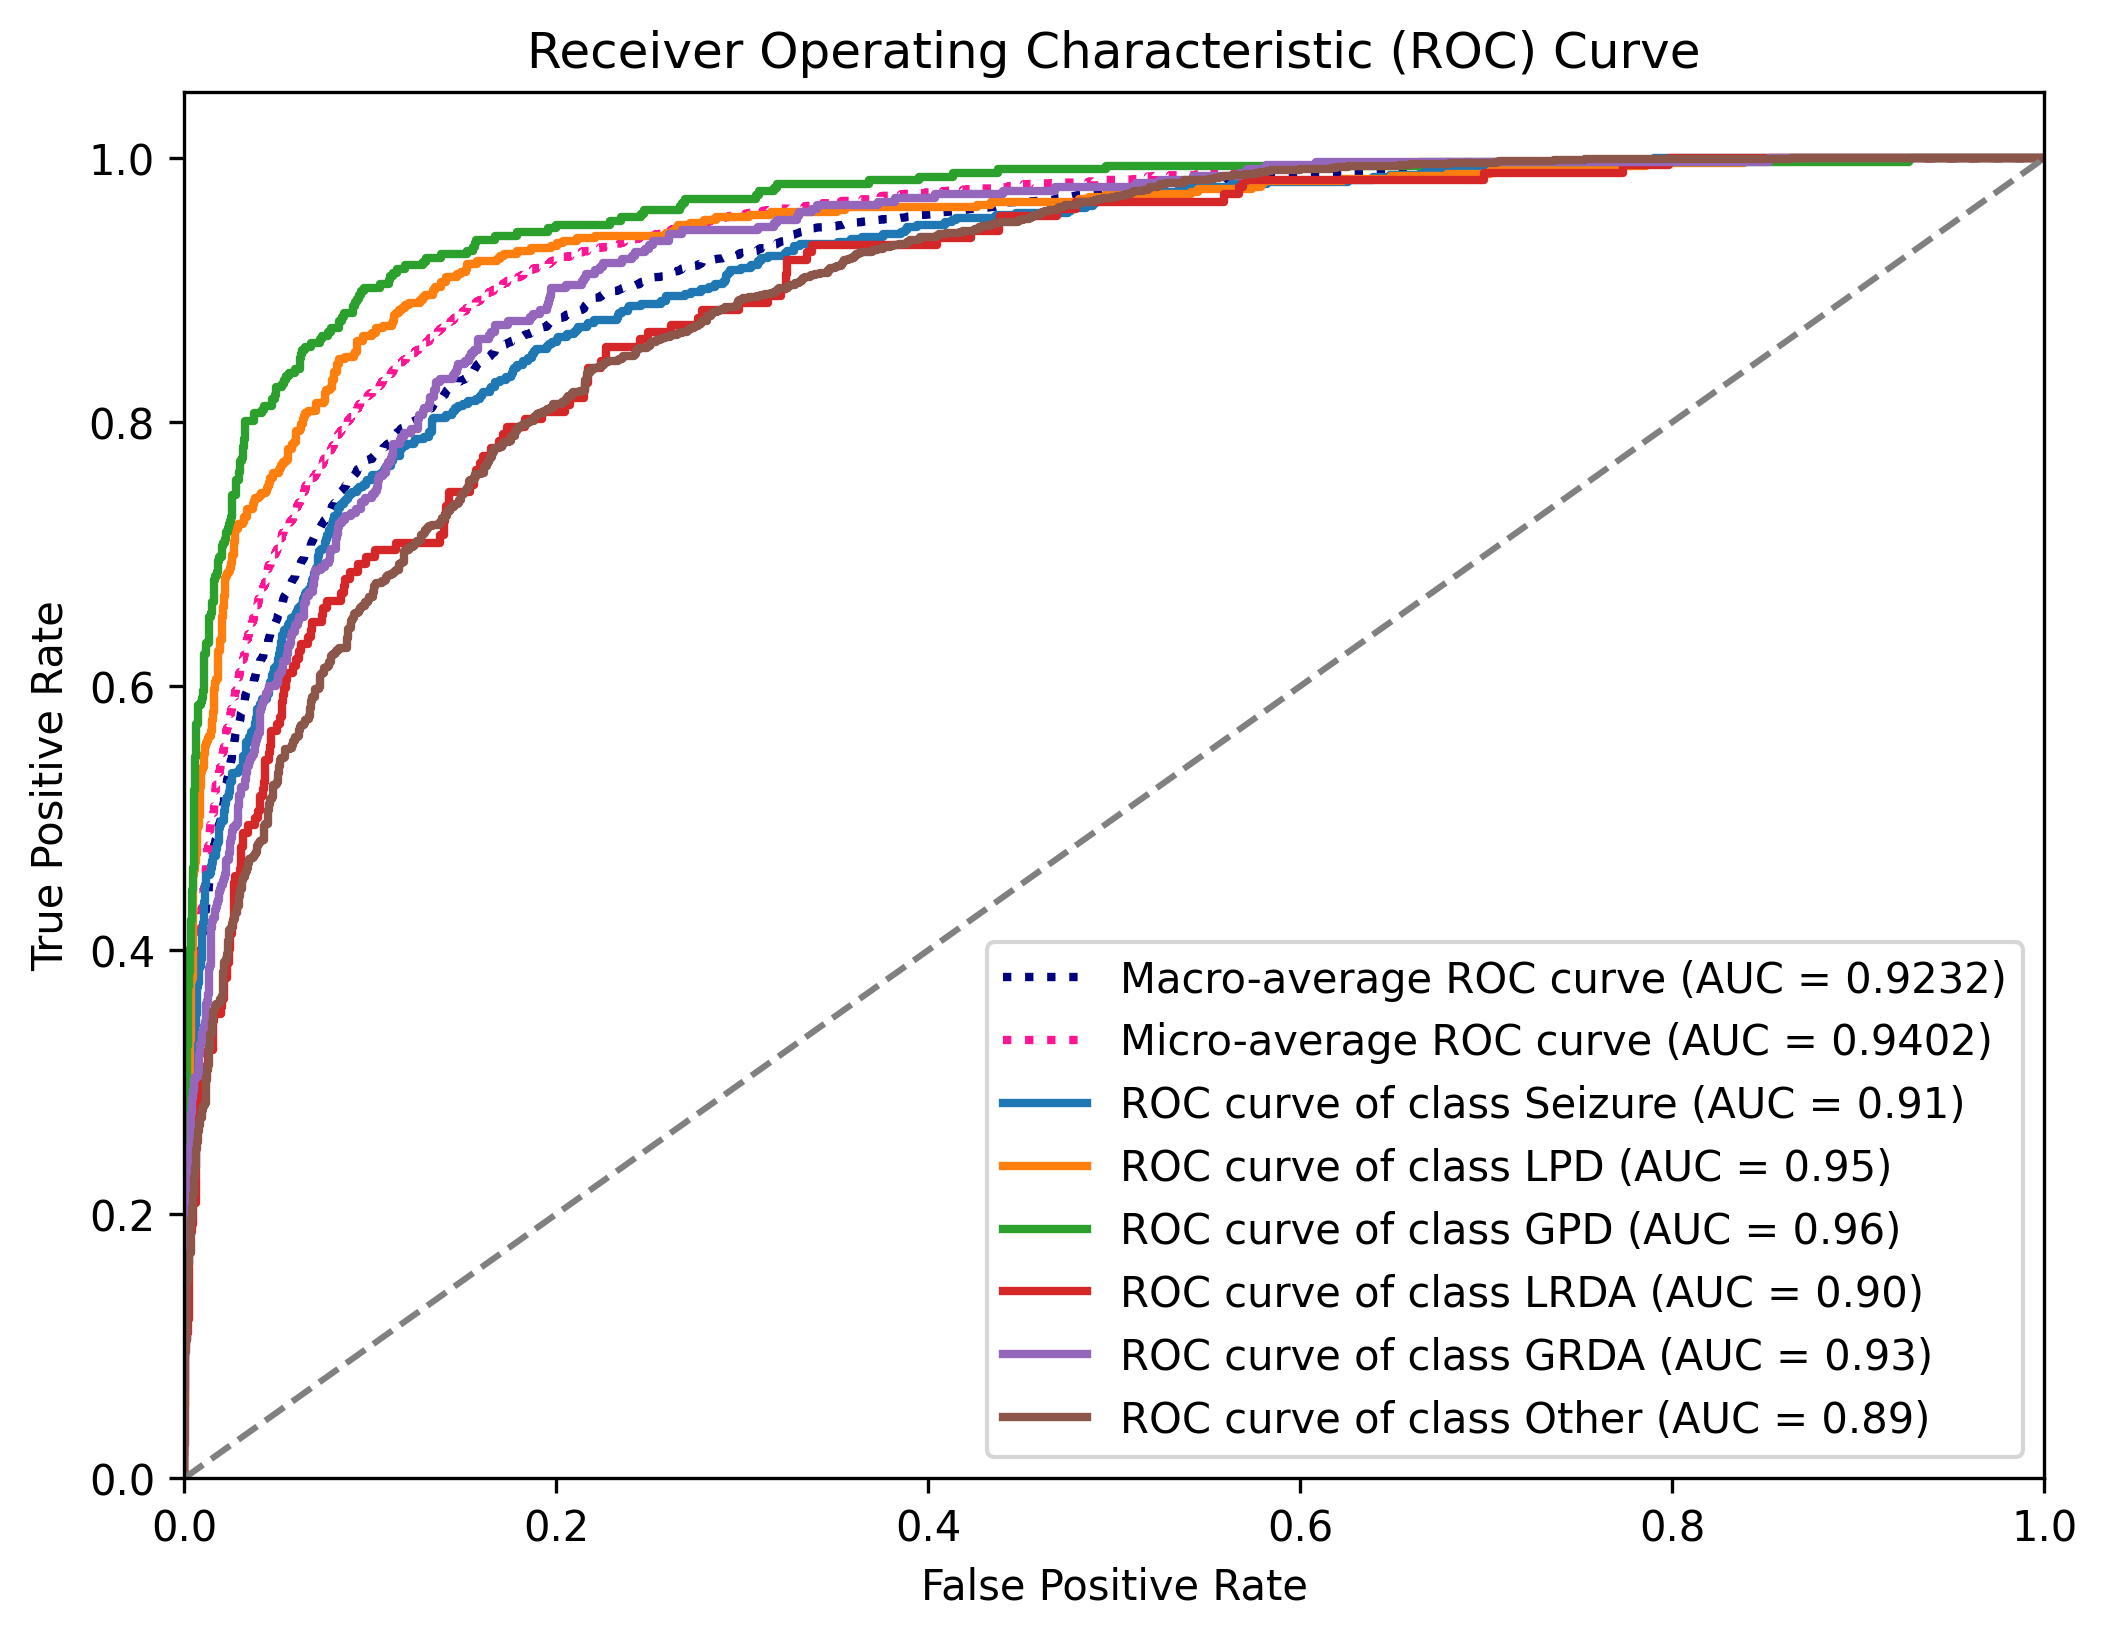

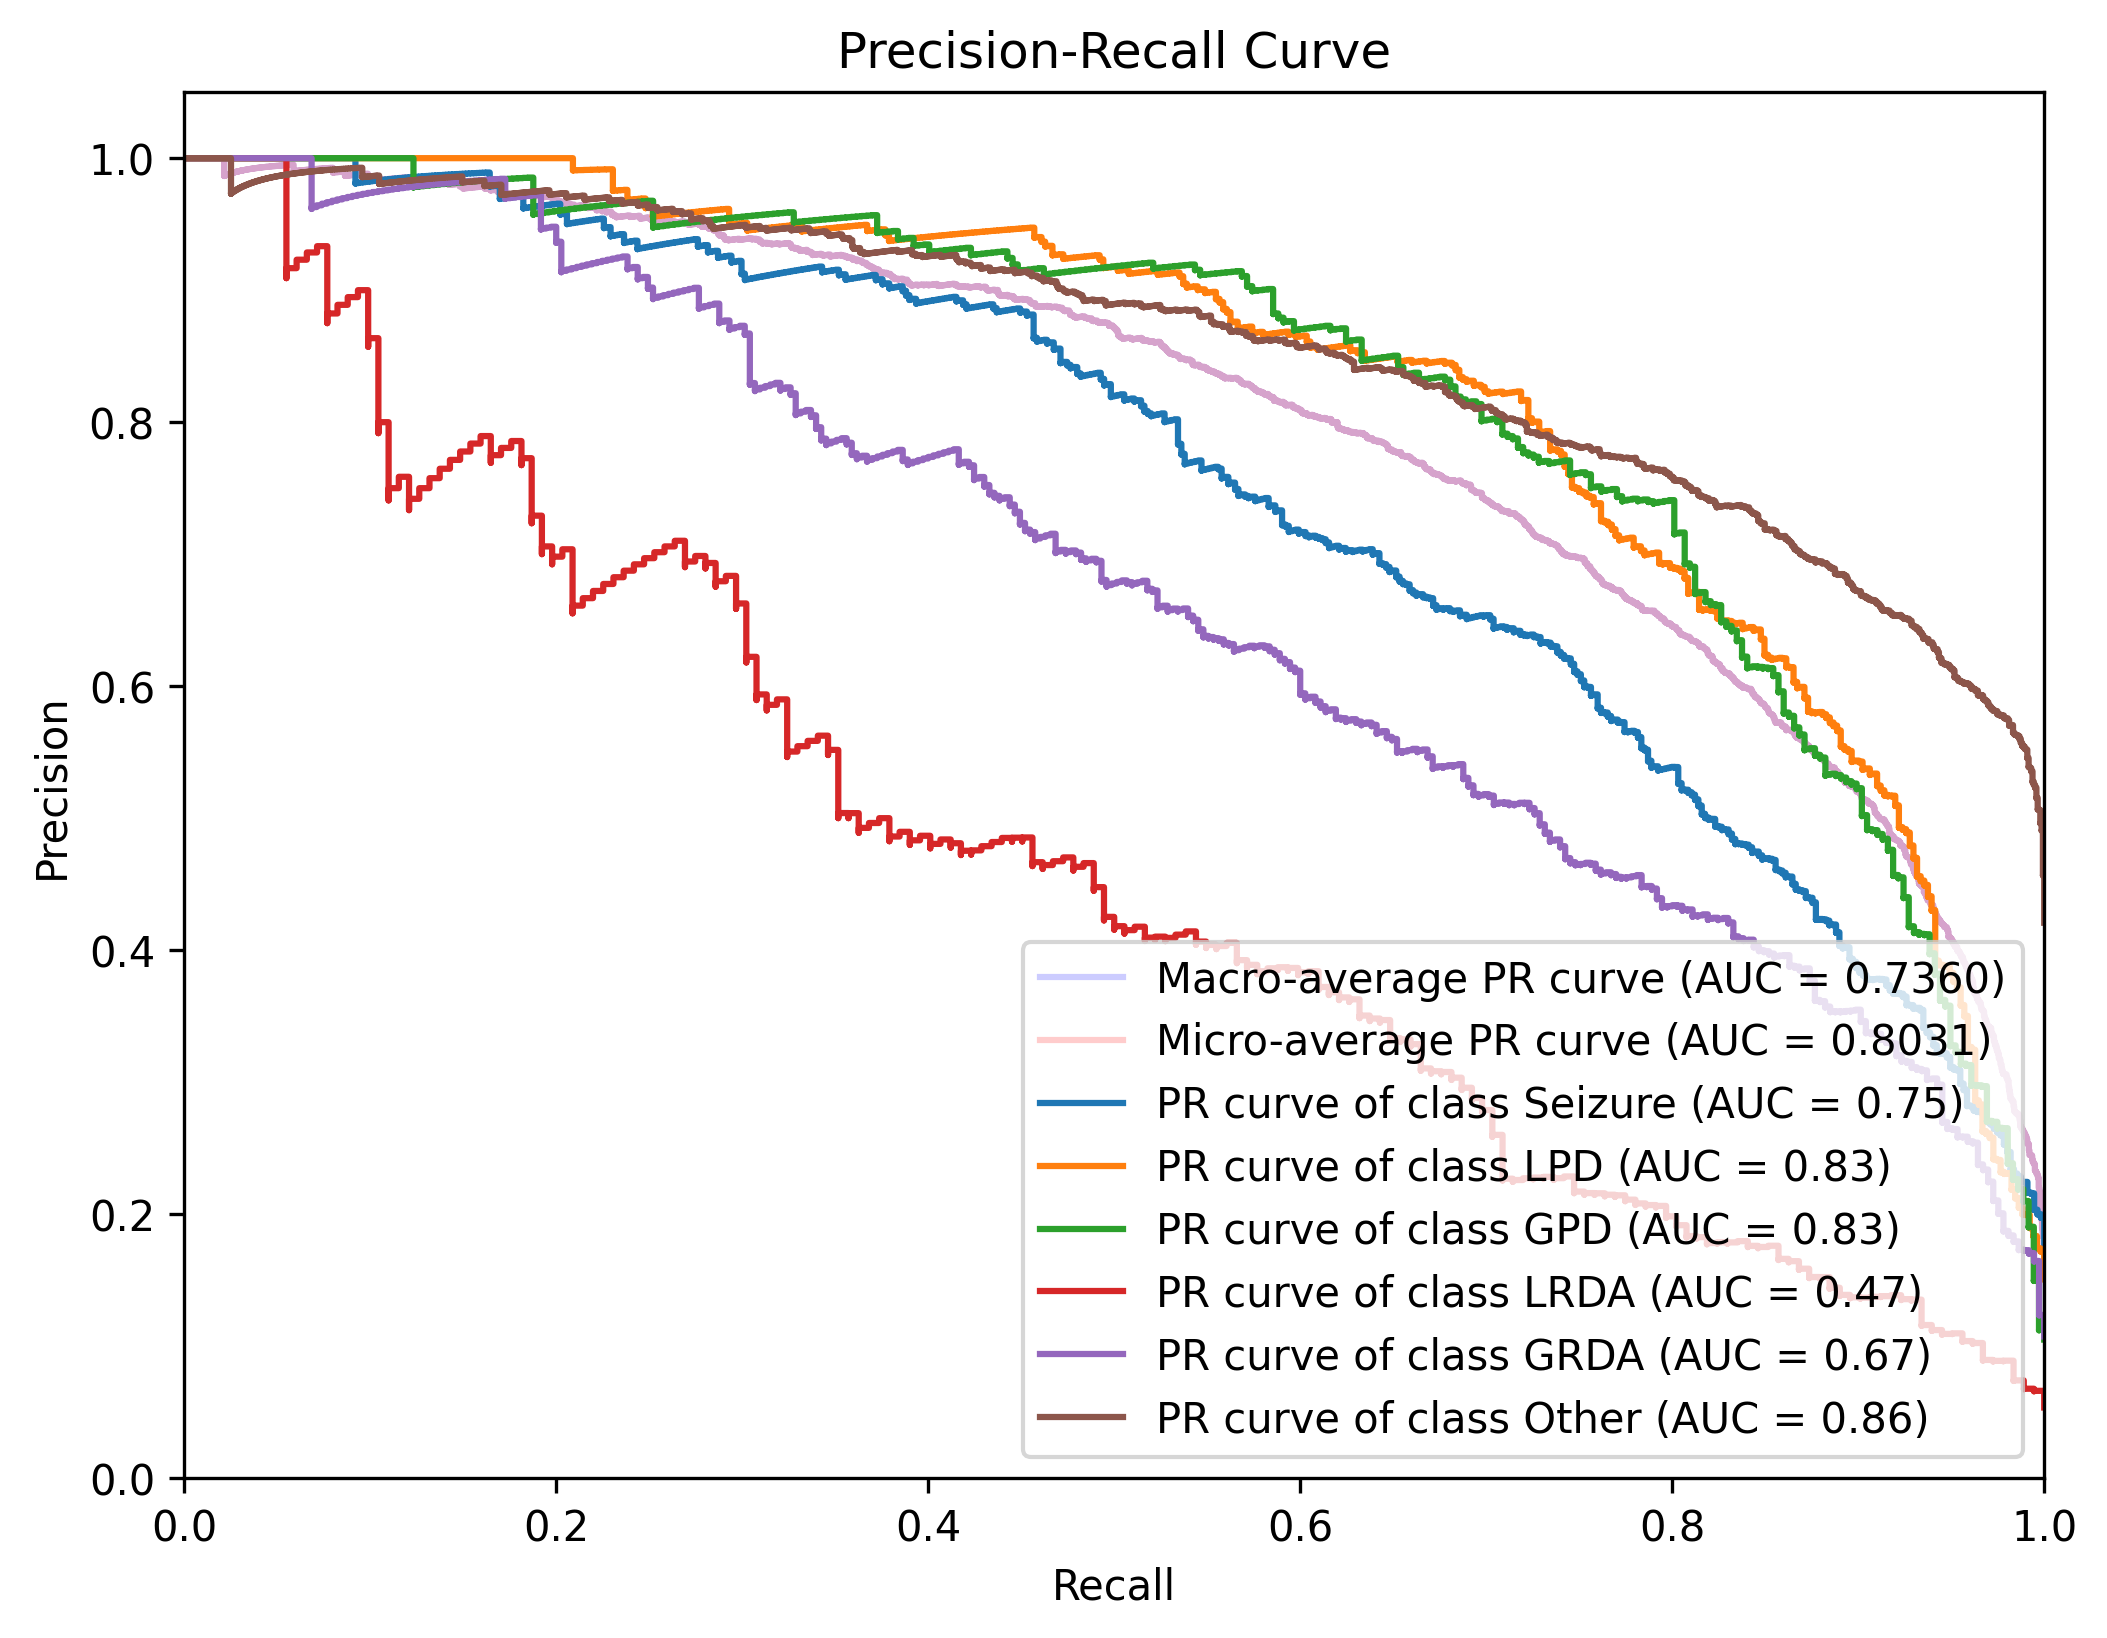

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_all_size, y_trans, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

model_combined_all_size, y_pred, y_pred_proba = train_catboost_classifier(X_train, y_train, X_val, y_val, X_test, y_test, **params)

plot_multiclass_roc_auc(y_test, y_pred_proba, original_labels)
plot_multiclass_pr_auc(y_test, y_pred_proba, original_labels)

In [ ]:
x_512_005 = processed_sample_df_cleaned_512_005.iloc[:, :-4]
x_256_005 = processed_sample_df_cleaned_256_005.iloc[:, :-4]

X_combined_all_size = np.concatenate((X,x_512,x_256),axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_combined_all_size, y_trans, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

model_combined_all_size, y_pred, y_pred_proba = train_catboost_classifier(X_train, y_train, X_val, y_val, X_test, y_test, **params)

plot_multiclass_roc_auc(y_test, y_pred_proba, original_labels)
plot_multiclass_pr_auc(y_test, y_pred_proba, original_labels)

In [ ]:
# feature_importances = model_combined.get_feature_importance()

# X = processed_sample_df_cleaned.iloc[:, :-10]
# X_trans = processed_sample_df_cleaned_trans.iloc[:, :-4]

# feature_names = list(X.columns) + list(X_trans.columns)#有误，需注意

# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# importance_df.head()

In [ ]:
STOP HERE PLZ

Plot preparation for attention map

In [ ]:
y_pred.shape

In [ ]:
#查看测试集里被正确分类的项目
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X_combined, y_trans, np.arange(len(y_trans)), test_size=0.2, random_state=42, stratify=y_trans)
predicted_total = model_combined.predict(X_test).flatten()
correct_indices = np.where(predicted_total == y_test)[0]
correctly_classified = test_idx[correct_indices]


In [ ]:
print(correctly_classified)

In [ ]:
correctly_classified_samples = processed_sample_df_cleaned.loc[correctly_classified]

# 查看提取行的前几行
correctly_classified_samples.head(10)

In [34]:
eeg_montage_path = f"{PROCESSED_DATA_DIR}/eeg_data_dict.pickle"
with open(eeg_montage_path, 'rb') as handle:
    eeg_data_dict = pickle.load(handle)

In [35]:
eeg_id_test = "3200944311"
for index, (key, value) in enumerate(eeg_data_dict.items()):
    
    if value["eeg_id"] == eeg_id_test:
        probs = value["targets"]
        print(f"targets for {eeg_id_test} are {probs}")
        data_test = value["data"]
        print (f"data shape{data_test.shape}")
        
        na_count = data_test.isna().sum().sum()
        print(f"Number of NA values in data_test: {na_count}")
        
        # Nah to mean
        data_test_filled = data_test.apply(lambda x: x.fillna(x.mean()), axis=0)
        #print(f"Data after filling NA values:\n{data_test_filled}")
        
        break

targets for 3200944311 are [0.         0.         0.93333333 0.         0.         0.06666667]
data shape(10000, 19)
Number of NA values in data_test: 0


In [ ]:
data_spe_test = spectrogram_from_eeg_stft(data_test, spe_width=1024, n_fft=512, spe_win=128, display=False)
print(data_spe_test.shape)

In [ ]:
data_spe_log = np.log(data_spe_test + 1e-10)  # 避免log(0)

# 频率范围，底部为0Hz，顶部为19.89Hz
freqs = np.linspace(0, 19.89, 51)

# 时间点，每隔50个时间点显示一次
time_points = np.arange(1024)

# 创建子图，5行1列，共享x轴，减小图的总长度
fig, axs = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

# 子图标题列表
titles = ['LL', 'RR', 'LP', 'RP', 'Midline Area']

# 绘制每个子图并添加颜色棒
for i in range(5):
    cax = axs[i].imshow(data_spe_log[:, :, i], aspect='auto', origin='lower',
                        extent=[time_points.min(), time_points.max(), freqs.min(), freqs.max()])
                        #cmap='rainbow', vmin=np.min(data_spe_log), vmax=np.max(data_spe_log))
    axs[i].set_ylabel('Hz', fontsize=10,fontdict={'family': 'sans-serif','fontweight':'black','color': '#008000'})
    axs[i].set_title(titles[i], fontsize=10)
    axs[i].set_yticks(np.linspace(0, 20, 5))
    axs[i].set_yticklabels(np.round(np.linspace(0, 19.89, 5), 2), fontsize=8)
    
    # 添加单独的颜色棒
    cbar = fig.colorbar(cax, ax=axs[i], orientation='vertical', fraction=.02, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# 设置共享的x轴
x_ticks = np.arange(0, 1024,102.4)
axs[-1].set_xlabel('Time', fontsize=10,fontdict={'family': 'sans-serif','fontweight':'black','color': '#008000'})
axs[-1].set_xticks(x_ticks)
axs[-1].set_xticklabels((x_ticks*0.05).astype(int) , fontsize=8)

plt.tight_layout()
plt.show()




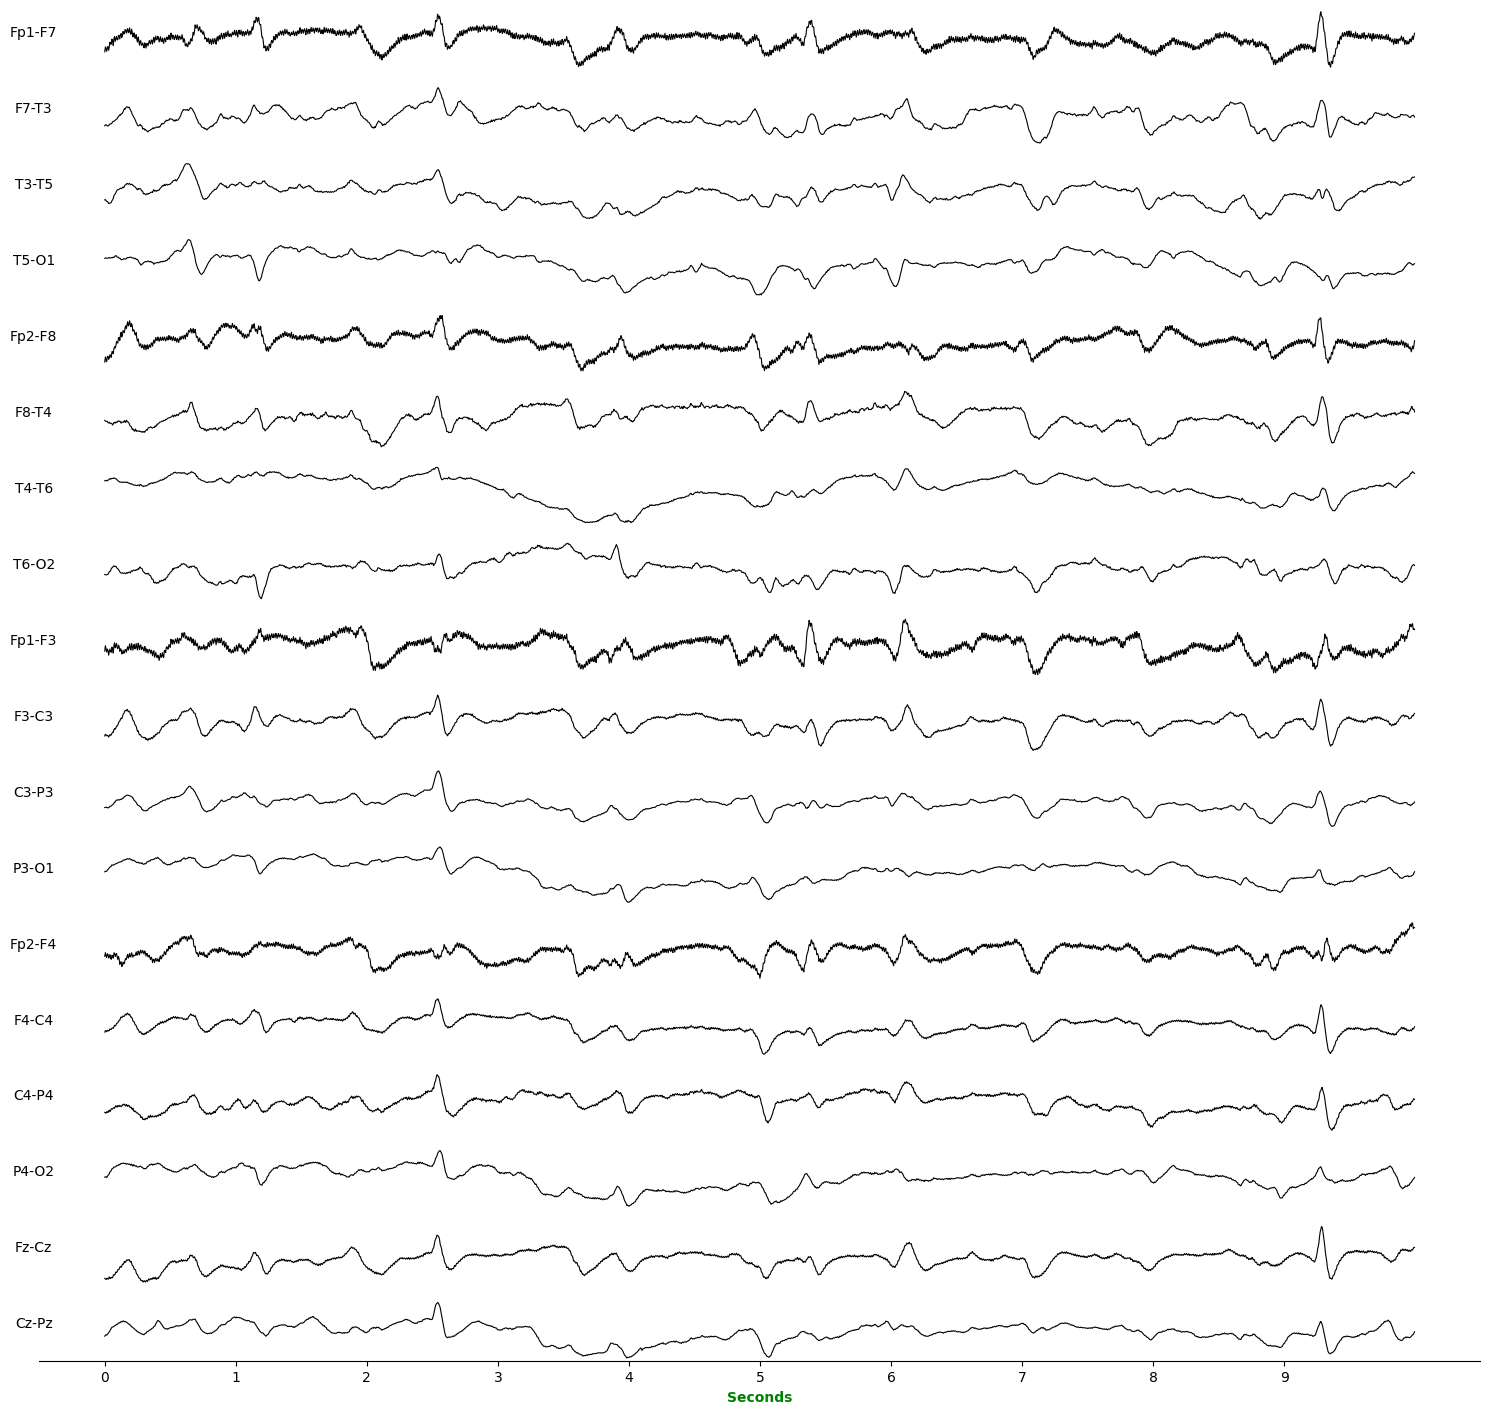

In [41]:
from scipy import signal

fs = 200

sos = signal.butter(4, [1, 40], btype="band", fs=200, output="sos")

def filt(data):
    return signal.sosfiltfilt(sos, data)

def plot_eeg(df, sub_fig=(15, 15), filter=False):
    fig, axs = plt.subplots(18, 1, figsize=sub_fig, sharex=True)
    for i, ax in enumerate(axs):
        if filter:
            ax.plot(filt(df.iloc[:, i]), color="black", linewidth=0.8)
        else:
            ax.plot(df.iloc[:, i], color="black", linewidth=0.8)
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.spines[["top", "left", "right"]].set_visible(False)
        if i < len(axs) - 1:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])  # 隐藏x轴刻度
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # 完全隐藏x轴及刻度

    # 在最后一个子图中设置x轴标签
    xticks = np.arange(0, len(df), 200)
    xticklabels = (xticks / 200).astype(int)  # 转换为秒数
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels(xticklabels)
    axs[-1].set_xlabel('Seconds', fontsize=10,
                       fontdict={'family': 'sans-serif', 'fontweight': 'black', 'color': '#008000'})

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # 调整布局，避免遮挡
    plt.show()
        
data_test_filled_10s = data_test_filled.iloc[4000:6000].reset_index(drop=True)
plot_eeg(data_test_filled_10s.drop(columns=["EKG"]))
#plot_eeg(data_test_filled.drop(columns=["EKG"]).iloc[4000:6000])

Generate attention map
Here we only use single montage
single sample shape:(51, 1024, 5)

In [ ]:
data_spe_log1p = np.log1p(data_spe_test + 1e-10)

In [ ]:
def interpolate_probability(value, x, y):
    # 线性插值计算
    x0, x1 = x[0], x[1]
    y0, y1 = y[0], y[1]
    interpolated_value = y0 + (value - x0) * (y1 - y0) / (x1 - x0)
    return max(interpolated_value, 1e-10)  # 避免返回0

def calculate_percentile(arr, value):
    return np.sum(arr < value) / len(arr) * 100

def calculate_log_likelihood_ratio(LL, processed_sample_df_cleaned_LL, percentiles):
    rows, cols = LL.shape
    log_likelihood_ratios = np.zeros((rows, cols))

    for n in range(rows):
        for m in range(cols):
            t = LL[n, m]
            cdf_value = calculate_percentile(LL[n, :], t)
            
            # 查找 cdf_value 在 percentiles 中的插入点
            percentile_idx = np.searchsorted(percentiles, cdf_value)
            
            if percentile_idx < len(percentiles) and percentiles[percentile_idx] == cdf_value:
                # 第一种情况：cdf_value 在 percentiles 里
                col_idx = percentile_idx * 51 + n
                col_data = processed_sample_df_cleaned_LL.iloc[:, col_idx]

                gpd_data = col_data[processed_sample_df_cleaned['target'] == 'GPD']
                non_gpd_data = col_data[processed_sample_df_cleaned['target'] != 'GPD']

                kde_gpd = gaussian_kde(gpd_data)
                kde_non_gpd = gaussian_kde(non_gpd_data)

                prob_gpd = kde_gpd.evaluate(t)[0]
                prob_non_gpd = kde_non_gpd.evaluate(t)[0]

            else:
                if cdf_value < 5:
                    # 第三种情况：cdf_value 在 0-5 之间
                    upper_idx = 0
                    col_idx_upper = upper_idx * 51 + n
                    col_data_upper = processed_sample_df_cleaned_LL.iloc[:, col_idx_upper]

                    gpd_data_upper = col_data_upper[processed_sample_df_cleaned['target'] == 'GPD']
                    non_gpd_data_upper = col_data_upper[processed_sample_df_cleaned['target'] != 'GPD']

                    kde_gpd_upper = gaussian_kde(gpd_data_upper)
                    kde_non_gpd_upper = gaussian_kde(non_gpd_data_upper)

                    prob_gpd_upper = kde_gpd_upper.evaluate(t)[0]
                    prob_non_gpd_upper = kde_non_gpd_upper.evaluate(t)[0]

                    prob_gpd = interpolate_probability(cdf_value, [0, percentiles[upper_idx]], [0, prob_gpd_upper])
                    prob_non_gpd = interpolate_probability(cdf_value, [0, percentiles[upper_idx]], [0, prob_non_gpd_upper])

                elif cdf_value > 95:
                    # 第四种情况：cdf_value 在 95-100 之间
                    lower_idx = len(percentiles) - 1
                    col_idx_lower = lower_idx * 51 + n
                    col_data_lower = processed_sample_df_cleaned_LL.iloc[:, col_idx_lower]

                    gpd_data_lower = col_data_lower[processed_sample_df_cleaned['target'] == 'GPD']
                    non_gpd_data_lower = col_data_lower[processed_sample_df_cleaned['target'] != 'GPD']

                    kde_gpd_lower = gaussian_kde(gpd_data_lower)
                    kde_non_gpd_lower = gaussian_kde(non_gpd_data_lower)

                    prob_gpd_lower = kde_gpd_lower.evaluate(t)[0]
                    prob_non_gpd_lower = kde_non_gpd_lower.evaluate(t)[0]

                    prob_gpd = interpolate_probability(cdf_value, [percentiles[lower_idx], 100], [prob_gpd_lower, 0])
                    prob_non_gpd = interpolate_probability(cdf_value, [percentiles[lower_idx], 100], [prob_non_gpd_lower, 0])

                else:
                    # 第二种情况：cdf_value 在 5-95 之间
                    lower_idx = max(0, percentile_idx - 1)
                    upper_idx = min(len(percentiles) - 1, percentile_idx)

                    col_idx_lower = lower_idx * 51 + n
                    col_idx_upper = upper_idx * 51 + n

                    col_data_lower = processed_sample_df_cleaned_LL.iloc[:, col_idx_lower]
                    col_data_upper = processed_sample_df_cleaned_LL.iloc[:, col_idx_upper]

                    gpd_data_lower = col_data_lower[processed_sample_df_cleaned['target'] == 'GPD']
                    gpd_data_upper = col_data_upper[processed_sample_df_cleaned['target'] == 'GPD']
                    non_gpd_data_lower = col_data_lower[processed_sample_df_cleaned['target'] != 'GPD']
                    non_gpd_data_upper = col_data_upper[processed_sample_df_cleaned['target'] != 'GPD']

                    kde_gpd_lower = gaussian_kde(gpd_data_lower)
                    kde_gpd_upper = gaussian_kde(gpd_data_upper)
                    kde_non_gpd_lower = gaussian_kde(non_gpd_data_lower)
                    kde_non_gpd_upper = gaussian_kde(non_gpd_data_upper)

                    prob_gpd_lower = kde_gpd_lower.evaluate(t)[0]
                    prob_gpd_upper = kde_gpd_upper.evaluate(t)[0]
                    prob_non_gpd_lower = kde_non_gpd_lower.evaluate(t)[0]
                    prob_non_gpd_upper = kde_non_gpd_upper.evaluate(t)[0]

                    prob_gpd = interpolate_probability(cdf_value, [percentiles[lower_idx], percentiles[upper_idx]], [prob_gpd_lower, prob_gpd_upper])
                    prob_non_gpd = interpolate_probability(cdf_value, [percentiles[lower_idx], percentiles[upper_idx]], [prob_non_gpd_lower, prob_non_gpd_upper])

            log_likelihood_ratio = np.log(prob_gpd / prob_non_gpd)
            log_likelihood_ratios[n, m] = log_likelihood_ratio

    return log_likelihood_ratios


In [ ]:
LL = data_spe_log1p[:, :, 0]

processed_sample_df_cleaned_LL = processed_sample_df_cleaned.iloc[:, :510]

percentiles = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

log_likelihood_ratios = calculate_log_likelihood_ratio(LL, processed_sample_df_cleaned_LL, percentiles)

np.count_nonzero(np.isnan(log_likelihood_ratios))

In [ ]:
log_likelihood_ratios_total = np.zeros(data_spe_log1p.shape)

for i in range(data_spe_log1p.shape[2]):
    
    channel = data_spe_log1p[:, :, i]
    
    processed_sample_df_cleaned_channel = processed_sample_df_cleaned.iloc[:, i*510:(i+1)*510]
    
    log_likelihood_ratios = calculate_log_likelihood_ratio(channel, processed_sample_df_cleaned_channel, percentiles)
    
    log_likelihood_ratios_total[:,:,i]=log_likelihood_ratios
    

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(16, 8))

for i in range(log_likelihood_ratios_total.shape[2]):
    axs[i].imshow(log_likelihood_ratios_total[:, :, i], aspect='auto', origin='lower')
    axs[i].set_title(f'Log Likelihood Ratios - Channel {i+1}')
    axs[i].set_xlabel('Samples')
    axs[i].set_ylabel('Features')

plt.tight_layout()
plt.show()

In [ ]:
log_likelihood_ratios_total.shape

In [ ]:
combined_log_likelihood_ratios = np.vstack([log_likelihood_ratios_total[:, :, i] for i in range(log_likelihood_ratios_total.shape[2])])

# 打印拼接后的数组形状
print("Combined shape:", combined_log_likelihood_ratios.shape)

# 计算每列的和
column_sums = np.sum(combined_log_likelihood_ratios, axis=0)

print(column_sums.shape)

In [ ]:
column_sums_2d = column_sums.reshape(1, -1)  # 将一维数组转换为二维数组

# 显示列和的热图
plt.figure(figsize=(20, 2))  # 调整图像尺寸
plt.imshow(column_sums_2d, aspect='auto', cmap='Reds', origin='lower')
plt.colorbar(label='Sum of Log Likelihood Ratios')
plt.title("Column Sums of Combined Log Likelihood Ratios")
plt.xlabel("Combined Samples")
plt.ylabel("Sum of Log Likelihood Ratios")
plt.show()

In [ ]:
aggregation_size = 16
aggregated_column_sums = np.mean(column_sums.reshape(-1, aggregation_size), axis=1)

# 显示聚合后的热图
plt.figure(figsize=(20, 2
                    ))  # 调整图像尺寸
plt.imshow(aggregated_column_sums.reshape(1, -1), aspect='auto', cmap='Reds', origin='lower')
plt.colorbar(label='Sum of Log Likelihood Ratios')
plt.title("Aggregated Column Sums of Combined Log Likelihood Ratios")
plt.xlabel("Combined Samples")
plt.ylabel("Sum of Log Likelihood Ratios")
plt.show()

In [ ]:
max_idx = np.argmax(column_sums)
print("Max index in aggregated_column_sums:", max_idx)
max_idx = max_idx*(10000//1024)

start = max(max_idx-64, 0)
end = min(max_idx + 64, data_test_filled.shape[0])
extracted_data = data_test_filled.iloc[start:end]

plot_eeg(extracted_data.drop(columns=["EKG"]),sub_fig = (2,6),filter = False)

In [ ]:
top_10_min_indices = np.argsort(column_sums)[:10]
print("Top 10 min indices in column_sums:", top_10_min_indices)

In [ ]:
min_idx = 544*(10000//1024)

start = max(min_idx -64, 0)
end = min(min_idx  + 64, data_test_filled.shape[0])
extracted_data = data_test_filled.iloc[start:end]

plot_eeg(extracted_data.drop(columns=["EKG"]),sub_fig = (1,6),filter = False)

接下来做一个对X_combine的LR

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

# 将 y 进行 One-Hot 编码
y_one_hot = one_hot_encoder.fit_transform(y.to_numpy().reshape(-1, 1))
y_one_hot = y_one_hot.astype(int)


num_ones = np.sum(y_one_hot[:,1] == 1)
num_zeros = np.sum(y_one_hot[:,1]  == 0)


print(f"Number of 1s: {num_ones}")
print(f"Number of 0s: {num_zeros}")

In [ ]:
features_to_remove = perform_t_test(X_combined, y, positive_class = 0, alpha=0.05)


In [ ]:
X_combined_cleaned = np.delete(X_combined, features_to_remove, axis=1)
print(X_combined_cleaned.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_combined_cleaned, y_one_hot[:,0], test_size=0.25, random_state=42,stratify=y_one_hot[:,0])
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
plot_pdf_combined_classes(X_train_scaled[:,800:808], y_train, ["Not Seizure","Seizure"], features_per_row=4, linespace = 50, bw_method=0.2)

In [ ]:
log_reg,y_pred,y_prob = logistic_regression_analysis(X_train_scaled, y_train, X_test_scaled, y_test, 
                                 penalty='l1', C=100, solver='saga', max_iter=1000, 
                                 class_weight='balanced', tol=1e-4, verbose=1, n_jobs=-1,
                                 plot_roc=True)


In [ ]:
print(y_prob.shape)
plot_pr_curve(y_test, y_prob)



In [ ]:
models = []
y_preds = []
y_probs = []
y_tests = [] 

for i,classes in enumerate(original_labels):
    print(f"ONE VS REST LR For {classes}")
    
    features_to_remove = perform_t_test(X_combined, y_one_hot[:,i], positive_class = 1, alpha=0.05)
    X_combined_cleaned = np.delete(X_combined, features_to_remove, axis=1)
    
    print("Start training")
    X_train, X_test, y_train, y_test = train_test_split(X_combined_cleaned, y_one_hot[:,i], test_size=0.25, random_state=42,stratify=y_one_hot[:,i])
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # y prob will only return a colomn of the probablities of positive labels
    log_reg,y_pred,y_prob = logistic_regression_analysis(X_train_scaled, y_train, X_test_scaled, y_test, 
                                 penalty='l1', C=100, solver='saga', max_iter=1000, 
                                 class_weight='balanced', tol=1e-4, verbose=1, n_jobs=-1,
                                 plot_roc=False)
    models.append(log_reg)
    y_preds.append(y_pred)
    y_probs.append(y_prob)
    y_tests.append(y_test) 

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# 聚合所有类的真实标签和预测概率
all_y_true = np.concatenate(y_tests)
all_y_prob = np.concatenate(y_probs)

# 计算每个类的ROC曲线和AUC
for i, classes in enumerate(original_labels):
    fpr[i], tpr[i], _ = roc_curve(y_tests[i], y_probs[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_y_true.ravel(), all_y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 计算macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(original_labels))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(original_labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(original_labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制ROC曲线
plt.figure(figsize=(6, 4))

for i, classes in enumerate(original_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {classes} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4, label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:

precision = dict()
recall = dict()
pr_auc = dict()

# 聚合所有类的真实标签和预测概率
all_y_true = np.concatenate(y_tests)
all_y_prob = np.concatenate(y_probs)

# 计算每个类的PR曲线和AUC
for i, classes in enumerate(original_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_tests[i], y_probs[i])
    pr_auc[i] = average_precision_score(y_tests[i], y_probs[i])

# 计算micro-average PR curve and PR AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_y_true.ravel(), all_y_prob.ravel())
pr_auc["micro"] = average_precision_score(all_y_true, all_y_prob, average="micro")

# 计算macro-average PR curve and PR AUC
precision["macro"], recall["macro"], _ = precision_recall_curve(all_y_true, all_y_prob)
pr_auc["macro"] = average_precision_score(all_y_true, all_y_prob, average="macro")

# 绘制PR曲线
plt.figure(figsize=(8, 6))

for i, classes in enumerate(original_labels):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve of class {classes} (AUC = {pr_auc[i]:.2f})')

plt.plot(recall["micro"], precision["micro"], color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average PR curve (AUC = {pr_auc["micro"]:.2f})')
plt.plot(recall["macro"], precision["macro"], color='navy', linestyle=':', linewidth=4, label=f'Macro-average PR curve (AUC = {pr_auc["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()
